Импортируем нужные библиотеки.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from collections import Counter
from tqdm import tqdm
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

Распакуйте архив с данными в папку, где находится этот jupyter notebook (baseline.ipynb). У Вас будет папка data,  содержащая необходимые файлы. 

В данном соревновании перед вами ставится задача предсказания категории возраста, к которой принадлежит клиент банка, на основании его транзакций.
В обучающем наборе содержатся информация по транзакциям 30000 клиентов, она находится в файле **transactions_train.csv**. Правильная категория возраста для обучающего набора находится в файле **train_target.csv**.

Считаем данные по транзакциям и правильные ответы.

In [2]:
transactions_train=pd.read_csv('data/transactions_train.csv')

In [3]:
train_target=pd.read_csv('data/train_target.csv')

Посмотрим на данные.

In [4]:
transactions_train.head()

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017
2,33172,8,11,13.887
3,33172,9,11,15.983
4,33172,10,11,21.341


* client_id - уникальный идентификатор клиента
* trans_date - дата совершения транзакции
* small_group - категория покупки
* amount_rur - сумма транзакции

In [5]:
train_target.head(5)

,client_id,bins
0,24662,2
1,1046,0
2,34089,2
3,34848,1
4,47076,3


* client_id - уникальный идентификатор клиента, соответствует полю client_id из транзакций
* bins - целевая переменная, которую нужно предсказать, это категория возраста клиента

Далее представлен простой вариант решения задачи. Вы можете решать соревнование используя совершенно другой подход.

Посчитаем по каждому клиенту самые простые аггрегационные признаки.

In [6]:
agg_features=transactions_train.groupby('client_id')['amount_rur'].agg(['sum','mean','std','min','max', 'count']).reset_index()

In [7]:
agg_features.head()

,client_id,sum,mean,std,min,max,count
0,4,28404.121,39.450168,73.511624,0.043,1341.802,720
1,6,15720.739,21.535259,26.200397,0.045,315.781,730
2,7,53630.036,69.379089,253.261383,0.043,4505.971,773
3,10,34419.365,48.752642,63.191701,0.045,654.893,706
4,11,26789.404,32.991877,107.395139,0.388,2105.058,812


Посчитаем для каждого клиента количество транзакций по каждой категории.

In [8]:
counter_df_train=transactions_train.groupby(['client_id','small_group'])['amount_rur'].count()

In [9]:
cat_counts_train=counter_df_train.reset_index().pivot(index='client_id', \
                                                      columns='small_group',values='amount_rur')

In [10]:
cat_counts_train=cat_counts_train.fillna(0)

In [11]:
cat_counts_train.columns=['small_group_'+str(i) for i in cat_counts_train.columns]

In [12]:
cat_counts_train.head()

,small_group_0,small_group_1,small_group_2,small_group_3,small_group_4,small_group_5,small_group_6,small_group_7,small_group_8,small_group_9,...,small_group_192,small_group_193,small_group_195,small_group_196,small_group_197,small_group_198,small_group_199,small_group_200,small_group_202,small_group_203
client_id,,,,,,,,,,,,,,,,,,,,,
4,0.0,447.0,1.0,44.0,93.0,0.0,0.0,0.0,1.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.0,397.0,0.0,172.0,10.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,79.0,5.0,27.0,19.0,1.0,0.0,2.0,1.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,12.0,309.0,1.0,71.0,65.0,0.0,0.0,0.0,3.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,2.0,423.0,0.0,59.0,23.0,3.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Далее соединим все файлы в один датафрейм с таргетом.

In [13]:
train=pd.merge(train_target,agg_features,on='client_id')

In [14]:
train=pd.merge(train,cat_counts_train.reset_index(),on='client_id')

In [15]:
train.head()

,client_id,bins,sum,mean,std,min,max,count,small_group_0,small_group_1,...,small_group_192,small_group_193,small_group_195,small_group_196,small_group_197,small_group_198,small_group_199,small_group_200,small_group_202,small_group_203
0,24662,2,30254.011,34.774725,72.037354,0.074,1227.314,870,0.0,174.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1046,0,42548.570,52.015367,106.540962,0.550,1210.506,818,1.0,187.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34089,2,26842.816,34.325852,59.927450,0.043,782.641,782,0.0,372.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34848,1,15773.126,16.160990,14.224936,0.043,109.590,976,0.0,359.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,47076,3,12488.375,15.929050,35.473591,0.432,541.165,784,0.0,378.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Произведём нормализацию данных о транзакциях по каждой категории.

Для чего нужна нормализация?  

Давайте представим себе двух клиентов. Пусть (при прочих равных) оба совершали покупки только в 0 и 1 small_group, причём первый клиент совершил 750 и 250 покупок, соответственно, а второй - 600 и 200.  
В принципе, для человека понятно, что данные клиенты скорее всего относятся к одной и той же категории: три четверти покупок у обоих относятся к нулевой группе, а оставшаяся четверть покупок относится к первой группе, что в какой-то степени роднит данных покупателей.  
Тем не менее, некоторые модели не смогут восстановить подобную зависимость, так как количества покупок для клиентов различны, потому стоит отнормализовать признаки, чтобы хранить не абсолютное количество покупок, а относительное.

In [16]:
for column in train.columns[8:]:
    train[column] /= train['count']

Добавим информацию об ещё одной мере изменчивости данных - диапазоне, а также изменим названия некоторых признаков, чтобы они не пересекались с ключевыми словами python.

In [17]:
train['range_value'] = train['max'] - train['min']
replace = ['sum', 'min', 'max']
for name in replace:
    train[name + '_value'] = train[name].copy()
    del train[name]

Разделим данные на train и valid выборки, что впоследствии поможет нам избежать переобучение. 

In [18]:
X = train.copy()
y = X['bins']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = .2, random_state = 53)

Посмотрим на среднее и стандартное отклонение по некоторым признакам. 

In [19]:
aggregable_features = ['sum_value', 'mean', 'std', 'max_value', 'range_value']
classes = sorted(train['bins'].unique())
X_train.groupby('bins')[aggregable_features].agg(['mean', 'std'])

sum_value                     mean                     std  \
              mean           std       mean         std        mean   
bins                                                                  
0     46017.759420  38987.757597  51.534932   41.817186  140.437801   
1     61840.227698  98240.670248  71.421559  118.507099  194.912186   
2     28348.564069  19714.152045  31.835603   22.216063   84.605634   
3     60225.991698  61948.460005  67.859980   68.318365  184.323455   

                    max_value               range_value               
             std         mean          std         mean          std  
bins                                                                  
0     204.956750  2622.331520  5081.198589  2622.031301  5081.181466  
1     525.171377  3512.530950  9982.457975  3511.974880  9982.411729  
2     142.825290  1584.728033  3424.003768  1584.532289  3424.003309  
3     336.440313  3366.241610  7897.497458  3365.848563  7897.491179

Как мы видим, нередко стандартное отклонение величины превышает среднее значение.  


Учитывая, что все значения данных признаков положительны, можно сделать вывод о наличии "выбросов" - значений, значительно отличающихся от большинства.  


Их наличие в обучающей выборке может снизить обобщающую способность модели. Иными словами, модель, чтобы научиться хорошо предсказывать исключительные и редкие случаи, может начать хуже работать на основной части данных. Следовательно, стоит избавиться от выбросов.

Исключим из train выборки значения, которые превышают $99$-й перцентиль хотя бы по одному из рассмотренных выше признаков.  

**Важно заметить, что мы не исключаем выбросы из valid выборки.**

In [20]:
percentile = {}
for i in classes:
    percentile[i] = {'conditions': '('}
    for feature in aggregable_features[:-1]:
        percentile[i][feature] = X_train[X_train['bins'] == i][feature].quantile(0.99)
        percentile[i]['conditions'] += '({} < {}) & '.format(feature, percentile[i][feature])
    percentile[i]['conditions'] = percentile[i]['conditions'][:-3] + ')'

In [21]:
for i in classes:
    string = '(bins != {}) | '.format(i) + percentile[i]['conditions']
    X_train = X_train.query(string)
y_train = X_train['bins']

Снова посмотрим на интересующие нас аггрегационные признаки.

In [22]:
aggregated = X_train.groupby('bins')[aggregable_features].agg(['mean', 'std'])
aggregated

sum_value                     mean                    std  \
              mean           std       mean        std        mean   
bins                                                                 
0     42858.346066  22424.987592  48.158434  24.263883  119.702177   
1     54839.663268  41826.021659  63.468489  46.474759  155.081508   
2     26832.384511  12086.089707  30.167940  12.964201   73.094631   
3     54898.150008  34699.001785  61.942036  38.034669  152.589752   

                    max_value               range_value               
             std         mean          std         mean          std  
bins                                                                  
0      99.974262  2143.636139  2362.799875  2143.339616  2362.785507  
1     165.569946  2674.023256  3424.665212  2673.472337  3424.635950  
2      50.812525  1315.639091  1181.001689  1315.444306  1180.993778  
3     144.628946  2670.239065  3169.858273  2669.849869  3169.862624

Как мы можем заметить, стандартные отклонения значительно уменьшились относительно средних значений по тем же признакам. Тем не менее, иногда стандартное отклонение превышает среднее значение. Безусловно, можно убрать из рассмотрения ещё некоторую часть данных, однако это может привести к недообучению модели, что ничуть не лучше переобучения. 

Пусть существует признак $a$, и для каждого из четёрых классов мы знаем его среднее значение $m_0, ... , m_3$. Помимо этого, у нас есть некая точка данных, для которое мы знаем значение $x$ признака $a$. Можно сделать предположение о том, что данная точка данных относится к классу, разность $x$ и среднего $m_i$ (где $i$ - индекс класса) является наименьшей по модулю.  
Однако, давайте рассмотрим ситуацию, при которой в одном (не умаляя общности, нулевом) классе $m_0 = 100$ и стандартное отклонение $std_0 = 1$, а в другом $m_1 = 90$ и $std_1 = 30$. Само значение $x = 110$. Интуитивно понятно, что данная точка данных с более высокой вероятностью относится к первому классу, чем к нулевому. Следовательно, стоит также учитывать и влияние стандартного отклонения.  

Создадим несколько признаков, опираясь на описанную выше логику.

In [23]:
for agg in tqdm(aggregable_features):
    for i in classes:
        X_train[str(agg) + '_dist_' + str(i)] = X_train[agg].apply(lambda x: (x - aggregated[agg]['mean'][i]) / aggregated[agg]['std'][i])
        X_valid[str(agg) + '_dist_' + str(i)] = X_valid[agg].apply(lambda x: (x - aggregated[agg]['mean'][i]) / aggregated[agg]['std'][i])

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [25:53<00:00, 310.72s/it]


Отвлечёмся от сбора информации, связанной с количеством потраченных денег и переключимся на сбор информации, связанной с днями совершения покупок. Соберём информацию о том, в какой день недели сколько покупок совершил клиент и произведём её нормализацию.

In [28]:
transactions_train['trans_date'] %= 7

In [25]:
idx_sum = 0
days = {}
for i in tqdm(list(transactions_train['client_id'].value_counts().items())):
    days[i[0]] = Counter(transactions_train.loc[idx_sum:idx_sum + i[1] - 1, 'trans_date'])
    idx_sum += i[1]

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:32<00:00, 933.57it/s]


In [26]:
for i in tqdm(range(7)):
    X_train['purchase_{}'.format(i)] = X_train['client_id'].apply(lambda x: days[x][i]) / X_train['count'] 
    X_valid['purchase_{}'.format(i)] = X_valid['client_id'].apply(lambda x: days[x][i]) / X_valid['count']

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.27it/s]


Заметим, что мы также можем отсортировать дни недели по тому, сколько покупок совершал клиент.  
Данные признаки будут категориальными, потому для удобства их обработки в задаче классификации затем воспользуемся моделью ***CatBoostClassifier***.

In [27]:
for i in tqdm(range(7)):
    X_train['popular_day_{}'.format(i)] = X_train['client_id'].apply(lambda x: days[x].most_common()[i][0])
    X_valid['popular_day_{}'.format(i)] = X_valid['client_id'].apply(lambda x: days[x].most_common()[i][0])

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.20it/s]


In [29]:
cat = CatBoostClassifier(iterations = 2000, learning_rate = 0.04, depth = 5, loss_function = 'MultiClass', eval_metric='Accuracy', random_state = 53)

In [30]:
cat_features = [X_train.shape[1] - 1 - 2 - 6 + i for i in range(7)]

In [31]:
cat.fit(X_train.loc[:, 'mean':], y_train, eval_set = (X_valid.loc[:, 'mean':], y_valid), cat_features = cat_features)

0:	learn: 0.5017389	test: 0.4950000	best: 0.4950000 (0)	total: 607ms	remaining: 20m 12s
1:	learn: 0.5100517	test: 0.5098333	best: 0.5098333 (1)	total: 1.05s	remaining: 17m 34s
2:	learn: 0.5118331	test: 0.5078333	best: 0.5098333 (1)	total: 1.73s	remaining: 19m 13s
3:	learn: 0.5136992	test: 0.5098333	best: 0.5098333 (1)	total: 2.2s	remaining: 18m 19s
4:	learn: 0.5153957	test: 0.5103333	best: 0.5103333 (4)	total: 2.73s	remaining: 18m 10s
5:	learn: 0.5173891	test: 0.5125000	best: 0.5125000 (5)	total: 3.19s	remaining: 17m 39s
6:	learn: 0.5240903	test: 0.5151667	best: 0.5151667 (6)	total: 3.7s	remaining: 17m 32s
7:	learn: 0.5246840	test: 0.5165000	best: 0.5165000 (7)	total: 4.21s	remaining: 17m 28s
8:	learn: 0.5245568	test: 0.5176667	best: 0.5176667 (8)	total: 4.81s	remaining: 17m 44s
9:	learn: 0.5279498	test: 0.5228333	best: 0.5228333 (9)	total: 5.21s	remaining: 17m 16s
10:	learn: 0.5283315	test: 0.5248333	best: 0.5248333 (10)	total: 5.79s	remaining: 17m 26s
11:	learn: 0.5300704	test: 0.525

92:	learn: 0.5896599	test: 0.5765000	best: 0.5773333 (91)	total: 51.2s	remaining: 17m 30s
93:	learn: 0.5899992	test: 0.5780000	best: 0.5780000 (93)	total: 51.7s	remaining: 17m 28s
94:	learn: 0.5901688	test: 0.5780000	best: 0.5780000 (93)	total: 52.2s	remaining: 17m 27s
95:	learn: 0.5906778	test: 0.5783333	best: 0.5783333 (95)	total: 52.7s	remaining: 17m 24s
96:	learn: 0.5908474	test: 0.5788333	best: 0.5788333 (96)	total: 53.2s	remaining: 17m 24s
97:	learn: 0.5914836	test: 0.5788333	best: 0.5788333 (96)	total: 53.7s	remaining: 17m 22s
98:	learn: 0.5916108	test: 0.5793333	best: 0.5793333 (98)	total: 54.2s	remaining: 17m 20s
99:	learn: 0.5919925	test: 0.5783333	best: 0.5793333 (98)	total: 54.6s	remaining: 17m 17s
100:	learn: 0.5926287	test: 0.5783333	best: 0.5793333 (98)	total: 55.1s	remaining: 17m 15s
101:	learn: 0.5926711	test: 0.5800000	best: 0.5800000 (101)	total: 55.5s	remaining: 17m 12s
102:	learn: 0.5932649	test: 0.5805000	best: 0.5805000 (102)	total: 56s	remaining: 17m 11s
103:	le

181:	learn: 0.6118415	test: 0.5925000	best: 0.5935000 (176)	total: 1m 33s	remaining: 15m 29s
182:	learn: 0.6119688	test: 0.5930000	best: 0.5935000 (176)	total: 1m 33s	remaining: 15m 31s
183:	learn: 0.6115447	test: 0.5936667	best: 0.5936667 (183)	total: 1m 34s	remaining: 15m 29s
184:	learn: 0.6115871	test: 0.5935000	best: 0.5936667 (183)	total: 1m 34s	remaining: 15m 30s
185:	learn: 0.6117143	test: 0.5936667	best: 0.5936667 (183)	total: 1m 35s	remaining: 15m 29s
186:	learn: 0.6118840	test: 0.5938333	best: 0.5938333 (186)	total: 1m 35s	remaining: 15m 30s
187:	learn: 0.6124353	test: 0.5930000	best: 0.5938333 (186)	total: 1m 36s	remaining: 15m 28s
188:	learn: 0.6119264	test: 0.5931667	best: 0.5938333 (186)	total: 1m 36s	remaining: 15m 27s
189:	learn: 0.6121384	test: 0.5935000	best: 0.5938333 (186)	total: 1m 37s	remaining: 15m 26s
190:	learn: 0.6119264	test: 0.5926667	best: 0.5938333 (186)	total: 1m 37s	remaining: 15m 26s
191:	learn: 0.6120960	test: 0.5935000	best: 0.5938333 (186)	total: 1m 

270:	learn: 0.6258801	test: 0.6035000	best: 0.6045000 (260)	total: 2m 19s	remaining: 14m 52s
271:	learn: 0.6261345	test: 0.6033333	best: 0.6045000 (260)	total: 2m 20s	remaining: 14m 51s
272:	learn: 0.6264738	test: 0.6030000	best: 0.6045000 (260)	total: 2m 20s	remaining: 14m 50s
273:	learn: 0.6269828	test: 0.6030000	best: 0.6045000 (260)	total: 2m 21s	remaining: 14m 49s
274:	learn: 0.6268131	test: 0.6036667	best: 0.6045000 (260)	total: 2m 21s	remaining: 14m 49s
275:	learn: 0.6271524	test: 0.6035000	best: 0.6045000 (260)	total: 2m 22s	remaining: 14m 48s
276:	learn: 0.6275766	test: 0.6036667	best: 0.6045000 (260)	total: 2m 22s	remaining: 14m 48s
277:	learn: 0.6278310	test: 0.6035000	best: 0.6045000 (260)	total: 2m 23s	remaining: 14m 48s
278:	learn: 0.6278310	test: 0.6033333	best: 0.6045000 (260)	total: 2m 23s	remaining: 14m 47s
279:	learn: 0.6279159	test: 0.6035000	best: 0.6045000 (260)	total: 2m 24s	remaining: 14m 46s
280:	learn: 0.6285945	test: 0.6020000	best: 0.6045000 (260)	total: 2m 

359:	learn: 0.6385190	test: 0.6080000	best: 0.6080000 (359)	total: 3m 2s	remaining: 13m 52s
360:	learn: 0.6391127	test: 0.6086667	best: 0.6086667 (360)	total: 3m 3s	remaining: 13m 52s
361:	learn: 0.6386462	test: 0.6081667	best: 0.6086667 (360)	total: 3m 3s	remaining: 13m 51s
362:	learn: 0.6388158	test: 0.6085000	best: 0.6086667 (360)	total: 3m 4s	remaining: 13m 50s
363:	learn: 0.6390703	test: 0.6088333	best: 0.6088333 (363)	total: 3m 4s	remaining: 13m 49s
364:	learn: 0.6390279	test: 0.6088333	best: 0.6088333 (363)	total: 3m 5s	remaining: 13m 49s
365:	learn: 0.6391127	test: 0.6091667	best: 0.6091667 (365)	total: 3m 5s	remaining: 13m 48s
366:	learn: 0.6391551	test: 0.6093333	best: 0.6093333 (366)	total: 3m 6s	remaining: 13m 48s
367:	learn: 0.6393672	test: 0.6091667	best: 0.6093333 (366)	total: 3m 6s	remaining: 13m 47s
368:	learn: 0.6395793	test: 0.6090000	best: 0.6093333 (366)	total: 3m 7s	remaining: 13m 47s
369:	learn: 0.6400882	test: 0.6085000	best: 0.6093333 (366)	total: 3m 7s	remaini

448:	learn: 0.6492917	test: 0.6116667	best: 0.6121667 (441)	total: 3m 45s	remaining: 12m 57s
449:	learn: 0.6491645	test: 0.6125000	best: 0.6125000 (449)	total: 3m 45s	remaining: 12m 56s
450:	learn: 0.6493765	test: 0.6128333	best: 0.6128333 (450)	total: 3m 46s	remaining: 12m 56s
451:	learn: 0.6495462	test: 0.6121667	best: 0.6128333 (450)	total: 3m 46s	remaining: 12m 55s
452:	learn: 0.6498007	test: 0.6126667	best: 0.6128333 (450)	total: 3m 47s	remaining: 12m 55s
453:	learn: 0.6497158	test: 0.6121667	best: 0.6128333 (450)	total: 3m 47s	remaining: 12m 54s
454:	learn: 0.6502672	test: 0.6125000	best: 0.6128333 (450)	total: 3m 48s	remaining: 12m 54s
455:	learn: 0.6503096	test: 0.6130000	best: 0.6130000 (455)	total: 3m 48s	remaining: 12m 53s
456:	learn: 0.6504793	test: 0.6136667	best: 0.6136667 (456)	total: 3m 49s	remaining: 12m 53s
457:	learn: 0.6505217	test: 0.6138333	best: 0.6138333 (457)	total: 3m 49s	remaining: 12m 52s
458:	learn: 0.6506065	test: 0.6138333	best: 0.6138333 (457)	total: 3m 

537:	learn: 0.6589193	test: 0.6116667	best: 0.6141667 (465)	total: 4m 29s	remaining: 12m 13s
538:	learn: 0.6593010	test: 0.6118333	best: 0.6141667 (465)	total: 4m 30s	remaining: 12m 13s
539:	learn: 0.6593435	test: 0.6125000	best: 0.6141667 (465)	total: 4m 30s	remaining: 12m 12s
540:	learn: 0.6594283	test: 0.6125000	best: 0.6141667 (465)	total: 4m 31s	remaining: 12m 12s
541:	learn: 0.6599796	test: 0.6123333	best: 0.6141667 (465)	total: 4m 31s	remaining: 12m 11s
542:	learn: 0.6600221	test: 0.6126667	best: 0.6141667 (465)	total: 4m 32s	remaining: 12m 10s
543:	learn: 0.6600645	test: 0.6123333	best: 0.6141667 (465)	total: 4m 32s	remaining: 12m 10s
544:	learn: 0.6602341	test: 0.6133333	best: 0.6141667 (465)	total: 4m 33s	remaining: 12m 10s
545:	learn: 0.6603189	test: 0.6143333	best: 0.6143333 (545)	total: 4m 33s	remaining: 12m 9s
546:	learn: 0.6603614	test: 0.6140000	best: 0.6143333 (545)	total: 4m 34s	remaining: 12m 9s
547:	learn: 0.6603614	test: 0.6133333	best: 0.6143333 (545)	total: 4m 34

626:	learn: 0.6689711	test: 0.6150000	best: 0.6158333 (575)	total: 5m 14s	remaining: 11m 29s
627:	learn: 0.6688862	test: 0.6155000	best: 0.6158333 (575)	total: 5m 15s	remaining: 11m 28s
628:	learn: 0.6687590	test: 0.6158333	best: 0.6158333 (575)	total: 5m 15s	remaining: 11m 28s
629:	learn: 0.6686742	test: 0.6151667	best: 0.6158333 (575)	total: 5m 16s	remaining: 11m 27s
630:	learn: 0.6683773	test: 0.6151667	best: 0.6158333 (575)	total: 5m 16s	remaining: 11m 27s
631:	learn: 0.6685470	test: 0.6156667	best: 0.6158333 (575)	total: 5m 17s	remaining: 11m 26s
632:	learn: 0.6686318	test: 0.6153333	best: 0.6158333 (575)	total: 5m 17s	remaining: 11m 26s
633:	learn: 0.6685894	test: 0.6155000	best: 0.6158333 (575)	total: 5m 18s	remaining: 11m 25s
634:	learn: 0.6684197	test: 0.6161667	best: 0.6161667 (634)	total: 5m 18s	remaining: 11m 25s
635:	learn: 0.6685894	test: 0.6158333	best: 0.6161667 (634)	total: 5m 19s	remaining: 11m 25s
636:	learn: 0.6688438	test: 0.6153333	best: 0.6161667 (634)	total: 5m 

715:	learn: 0.6753753	test: 0.6186667	best: 0.6190000 (709)	total: 5m 54s	remaining: 10m 35s
716:	learn: 0.6755026	test: 0.6188333	best: 0.6190000 (709)	total: 5m 55s	remaining: 10m 35s
717:	learn: 0.6753753	test: 0.6185000	best: 0.6190000 (709)	total: 5m 55s	remaining: 10m 34s
718:	learn: 0.6757995	test: 0.6188333	best: 0.6190000 (709)	total: 5m 55s	remaining: 10m 34s
719:	learn: 0.6755874	test: 0.6186667	best: 0.6190000 (709)	total: 5m 56s	remaining: 10m 33s
720:	learn: 0.6757146	test: 0.6186667	best: 0.6190000 (709)	total: 5m 56s	remaining: 10m 32s
721:	learn: 0.6757146	test: 0.6186667	best: 0.6190000 (709)	total: 5m 57s	remaining: 10m 32s
722:	learn: 0.6757146	test: 0.6188333	best: 0.6190000 (709)	total: 5m 57s	remaining: 10m 31s
723:	learn: 0.6759691	test: 0.6186667	best: 0.6190000 (709)	total: 5m 58s	remaining: 10m 30s
724:	learn: 0.6757146	test: 0.6185000	best: 0.6190000 (709)	total: 5m 58s	remaining: 10m 30s
725:	learn: 0.6759691	test: 0.6186667	best: 0.6190000 (709)	total: 5m 

804:	learn: 0.6820765	test: 0.6190000	best: 0.6198333 (731)	total: 6m 37s	remaining: 9m 50s
805:	learn: 0.6822037	test: 0.6191667	best: 0.6198333 (731)	total: 6m 38s	remaining: 9m 50s
806:	learn: 0.6822886	test: 0.6186667	best: 0.6198333 (731)	total: 6m 38s	remaining: 9m 49s
807:	learn: 0.6819917	test: 0.6185000	best: 0.6198333 (731)	total: 6m 39s	remaining: 9m 49s
808:	learn: 0.6822886	test: 0.6185000	best: 0.6198333 (731)	total: 6m 39s	remaining: 9m 48s
809:	learn: 0.6822886	test: 0.6188333	best: 0.6198333 (731)	total: 6m 40s	remaining: 9m 48s
810:	learn: 0.6823310	test: 0.6190000	best: 0.6198333 (731)	total: 6m 40s	remaining: 9m 47s
811:	learn: 0.6823734	test: 0.6193333	best: 0.6198333 (731)	total: 6m 41s	remaining: 9m 47s
812:	learn: 0.6825855	test: 0.6190000	best: 0.6198333 (731)	total: 6m 42s	remaining: 9m 46s
813:	learn: 0.6827551	test: 0.6195000	best: 0.6198333 (731)	total: 6m 42s	remaining: 9m 46s
814:	learn: 0.6827127	test: 0.6195000	best: 0.6198333 (731)	total: 6m 43s	remain

894:	learn: 0.6883960	test: 0.6183333	best: 0.6206667 (860)	total: 7m 26s	remaining: 9m 10s
895:	learn: 0.6884384	test: 0.6185000	best: 0.6206667 (860)	total: 7m 26s	remaining: 9m 10s
896:	learn: 0.6882263	test: 0.6180000	best: 0.6206667 (860)	total: 7m 27s	remaining: 9m 9s
897:	learn: 0.6883111	test: 0.6185000	best: 0.6206667 (860)	total: 7m 27s	remaining: 9m 9s
898:	learn: 0.6882263	test: 0.6191667	best: 0.6206667 (860)	total: 7m 28s	remaining: 9m 9s
899:	learn: 0.6880143	test: 0.6190000	best: 0.6206667 (860)	total: 7m 29s	remaining: 9m 8s
900:	learn: 0.6884384	test: 0.6193333	best: 0.6206667 (860)	total: 7m 29s	remaining: 9m 8s
901:	learn: 0.6887777	test: 0.6193333	best: 0.6206667 (860)	total: 7m 30s	remaining: 9m 8s
902:	learn: 0.6883960	test: 0.6193333	best: 0.6206667 (860)	total: 7m 30s	remaining: 9m 7s
903:	learn: 0.6884384	test: 0.6195000	best: 0.6206667 (860)	total: 7m 31s	remaining: 9m 7s
904:	learn: 0.6885656	test: 0.6198333	best: 0.6206667 (860)	total: 7m 31s	remaining: 9m 

984:	learn: 0.6936551	test: 0.6200000	best: 0.6220000 (966)	total: 8m 15s	remaining: 8m 30s
985:	learn: 0.6939096	test: 0.6195000	best: 0.6220000 (966)	total: 8m 15s	remaining: 8m 29s
986:	learn: 0.6939096	test: 0.6200000	best: 0.6220000 (966)	total: 8m 16s	remaining: 8m 29s
987:	learn: 0.6938672	test: 0.6196667	best: 0.6220000 (966)	total: 8m 16s	remaining: 8m 28s
988:	learn: 0.6940792	test: 0.6198333	best: 0.6220000 (966)	total: 8m 17s	remaining: 8m 28s
989:	learn: 0.6939944	test: 0.6193333	best: 0.6220000 (966)	total: 8m 17s	remaining: 8m 27s
990:	learn: 0.6941216	test: 0.6195000	best: 0.6220000 (966)	total: 8m 18s	remaining: 8m 27s
991:	learn: 0.6941641	test: 0.6196667	best: 0.6220000 (966)	total: 8m 19s	remaining: 8m 27s
992:	learn: 0.6939944	test: 0.6200000	best: 0.6220000 (966)	total: 8m 19s	remaining: 8m 26s
993:	learn: 0.6940792	test: 0.6201667	best: 0.6220000 (966)	total: 8m 20s	remaining: 8m 26s
994:	learn: 0.6942489	test: 0.6206667	best: 0.6220000 (966)	total: 8m 21s	remain

1073:	learn: 0.6992960	test: 0.6216667	best: 0.6220000 (966)	total: 9m 4s	remaining: 7m 49s
1074:	learn: 0.6989991	test: 0.6216667	best: 0.6220000 (966)	total: 9m 5s	remaining: 7m 49s
1075:	learn: 0.6991263	test: 0.6216667	best: 0.6220000 (966)	total: 9m 5s	remaining: 7m 48s
1076:	learn: 0.6992535	test: 0.6216667	best: 0.6220000 (966)	total: 9m 6s	remaining: 7m 48s
1077:	learn: 0.6994656	test: 0.6220000	best: 0.6220000 (966)	total: 9m 7s	remaining: 7m 47s
1078:	learn: 0.6994656	test: 0.6218333	best: 0.6220000 (966)	total: 9m 7s	remaining: 7m 47s
1079:	learn: 0.6995080	test: 0.6220000	best: 0.6220000 (966)	total: 9m 8s	remaining: 7m 46s
1080:	learn: 0.6998049	test: 0.6215000	best: 0.6220000 (966)	total: 9m 8s	remaining: 7m 46s
1081:	learn: 0.6995928	test: 0.6216667	best: 0.6220000 (966)	total: 9m 9s	remaining: 7m 45s
1082:	learn: 0.6995080	test: 0.6215000	best: 0.6220000 (966)	total: 9m 9s	remaining: 7m 45s
1083:	learn: 0.6994656	test: 0.6218333	best: 0.6220000 (966)	total: 9m 10s	remai

1161:	learn: 0.7033251	test: 0.6210000	best: 0.6226667 (1135)	total: 9m 53s	remaining: 7m 7s
1162:	learn: 0.7033251	test: 0.6213333	best: 0.6226667 (1135)	total: 9m 53s	remaining: 7m 7s
1163:	learn: 0.7035372	test: 0.6218333	best: 0.6226667 (1135)	total: 9m 54s	remaining: 7m 6s
1164:	learn: 0.7035372	test: 0.6218333	best: 0.6226667 (1135)	total: 9m 55s	remaining: 7m 6s
1165:	learn: 0.7035372	test: 0.6218333	best: 0.6226667 (1135)	total: 9m 55s	remaining: 7m 5s
1166:	learn: 0.7034524	test: 0.6220000	best: 0.6226667 (1135)	total: 9m 56s	remaining: 7m 5s
1167:	learn: 0.7034524	test: 0.6216667	best: 0.6226667 (1135)	total: 9m 56s	remaining: 7m 5s
1168:	learn: 0.7036220	test: 0.6218333	best: 0.6226667 (1135)	total: 9m 57s	remaining: 7m 4s
1169:	learn: 0.7039189	test: 0.6218333	best: 0.6226667 (1135)	total: 9m 57s	remaining: 7m 4s
1170:	learn: 0.7036644	test: 0.6220000	best: 0.6226667 (1135)	total: 9m 58s	remaining: 7m 3s
1171:	learn: 0.7035372	test: 0.6218333	best: 0.6226667 (1135)	total: 9

1248:	learn: 0.7074816	test: 0.6213333	best: 0.6228333 (1215)	total: 10m 25s	remaining: 6m 15s
1249:	learn: 0.7079057	test: 0.6213333	best: 0.6228333 (1215)	total: 10m 25s	remaining: 6m 15s
1250:	learn: 0.7076936	test: 0.6213333	best: 0.6228333 (1215)	total: 10m 25s	remaining: 6m 14s
1251:	learn: 0.7079481	test: 0.6213333	best: 0.6228333 (1215)	total: 10m 25s	remaining: 6m 13s
1252:	learn: 0.7076512	test: 0.6213333	best: 0.6228333 (1215)	total: 10m 26s	remaining: 6m 13s
1253:	learn: 0.7079481	test: 0.6210000	best: 0.6228333 (1215)	total: 10m 26s	remaining: 6m 12s
1254:	learn: 0.7081601	test: 0.6213333	best: 0.6228333 (1215)	total: 10m 26s	remaining: 6m 11s
1255:	learn: 0.7081601	test: 0.6216667	best: 0.6228333 (1215)	total: 10m 26s	remaining: 6m 11s
1256:	learn: 0.7082450	test: 0.6216667	best: 0.6228333 (1215)	total: 10m 26s	remaining: 6m 10s
1257:	learn: 0.7084146	test: 0.6216667	best: 0.6228333 (1215)	total: 10m 27s	remaining: 6m 9s
1258:	learn: 0.7082450	test: 0.6215000	best: 0.6228

1335:	learn: 0.7121893	test: 0.6206667	best: 0.6228333 (1215)	total: 10m 57s	remaining: 5m 26s
1336:	learn: 0.7123166	test: 0.6206667	best: 0.6228333 (1215)	total: 10m 58s	remaining: 5m 26s
1337:	learn: 0.7118076	test: 0.6206667	best: 0.6228333 (1215)	total: 10m 58s	remaining: 5m 26s
1338:	learn: 0.7121045	test: 0.6211667	best: 0.6228333 (1215)	total: 10m 59s	remaining: 5m 25s
1339:	learn: 0.7121893	test: 0.6205000	best: 0.6228333 (1215)	total: 11m	remaining: 5m 25s
1340:	learn: 0.7123590	test: 0.6196667	best: 0.6228333 (1215)	total: 11m	remaining: 5m 24s
1341:	learn: 0.7124014	test: 0.6198333	best: 0.6228333 (1215)	total: 11m 1s	remaining: 5m 24s
1342:	learn: 0.7125710	test: 0.6205000	best: 0.6228333 (1215)	total: 11m 1s	remaining: 5m 23s
1343:	learn: 0.7128679	test: 0.6210000	best: 0.6228333 (1215)	total: 11m 2s	remaining: 5m 23s
1344:	learn: 0.7129952	test: 0.6210000	best: 0.6228333 (1215)	total: 11m 2s	remaining: 5m 22s
1345:	learn: 0.7129528	test: 0.6208333	best: 0.6228333 (1215)	

1422:	learn: 0.7171940	test: 0.6208333	best: 0.6228333 (1215)	total: 11m 34s	remaining: 4m 41s
1423:	learn: 0.7174061	test: 0.6211667	best: 0.6228333 (1215)	total: 11m 35s	remaining: 4m 41s
1424:	learn: 0.7174061	test: 0.6211667	best: 0.6228333 (1215)	total: 11m 35s	remaining: 4m 40s
1425:	learn: 0.7175757	test: 0.6213333	best: 0.6228333 (1215)	total: 11m 35s	remaining: 4m 40s
1426:	learn: 0.7172788	test: 0.6215000	best: 0.6228333 (1215)	total: 11m 36s	remaining: 4m 39s
1427:	learn: 0.7175757	test: 0.6213333	best: 0.6228333 (1215)	total: 11m 36s	remaining: 4m 38s
1428:	learn: 0.7175333	test: 0.6213333	best: 0.6228333 (1215)	total: 11m 36s	remaining: 4m 38s
1429:	learn: 0.7173212	test: 0.6215000	best: 0.6228333 (1215)	total: 11m 36s	remaining: 4m 37s
1430:	learn: 0.7176605	test: 0.6221667	best: 0.6228333 (1215)	total: 11m 37s	remaining: 4m 37s
1431:	learn: 0.7175333	test: 0.6221667	best: 0.6228333 (1215)	total: 11m 37s	remaining: 4m 36s
1432:	learn: 0.7175757	test: 0.6223333	best: 0.622

1509:	learn: 0.7210959	test: 0.6221667	best: 0.6228333 (1215)	total: 11m 56s	remaining: 3m 52s
1510:	learn: 0.7209687	test: 0.6221667	best: 0.6228333 (1215)	total: 11m 56s	remaining: 3m 51s
1511:	learn: 0.7210535	test: 0.6215000	best: 0.6228333 (1215)	total: 11m 56s	remaining: 3m 51s
1512:	learn: 0.7210111	test: 0.6213333	best: 0.6228333 (1215)	total: 11m 56s	remaining: 3m 50s
1513:	learn: 0.7210535	test: 0.6213333	best: 0.6228333 (1215)	total: 11m 57s	remaining: 3m 50s
1514:	learn: 0.7210959	test: 0.6213333	best: 0.6228333 (1215)	total: 11m 57s	remaining: 3m 49s
1515:	learn: 0.7211383	test: 0.6216667	best: 0.6228333 (1215)	total: 11m 57s	remaining: 3m 49s
1516:	learn: 0.7213928	test: 0.6213333	best: 0.6228333 (1215)	total: 11m 57s	remaining: 3m 48s
1517:	learn: 0.7213504	test: 0.6213333	best: 0.6228333 (1215)	total: 11m 58s	remaining: 3m 47s
1518:	learn: 0.7213504	test: 0.6211667	best: 0.6228333 (1215)	total: 11m 58s	remaining: 3m 47s
1519:	learn: 0.7212656	test: 0.6213333	best: 0.622

1597:	learn: 0.7243617	test: 0.6221667	best: 0.6228333 (1215)	total: 12m 16s	remaining: 3m 5s
1598:	learn: 0.7244041	test: 0.6218333	best: 0.6228333 (1215)	total: 12m 16s	remaining: 3m 4s
1599:	learn: 0.7243617	test: 0.6215000	best: 0.6228333 (1215)	total: 12m 16s	remaining: 3m 4s
1600:	learn: 0.7245313	test: 0.6208333	best: 0.6228333 (1215)	total: 12m 16s	remaining: 3m 3s
1601:	learn: 0.7247010	test: 0.6211667	best: 0.6228333 (1215)	total: 12m 17s	remaining: 3m 3s
1602:	learn: 0.7247434	test: 0.6208333	best: 0.6228333 (1215)	total: 12m 17s	remaining: 3m 2s
1603:	learn: 0.7247010	test: 0.6205000	best: 0.6228333 (1215)	total: 12m 17s	remaining: 3m 2s
1604:	learn: 0.7247010	test: 0.6201667	best: 0.6228333 (1215)	total: 12m 17s	remaining: 3m 1s
1605:	learn: 0.7248282	test: 0.6203333	best: 0.6228333 (1215)	total: 12m 17s	remaining: 3m 1s
1606:	learn: 0.7250827	test: 0.6203333	best: 0.6228333 (1215)	total: 12m 18s	remaining: 3m
1607:	learn: 0.7251675	test: 0.6203333	best: 0.6228333 (1215)	t

1685:	learn: 0.7287302	test: 0.6230000	best: 0.6231667 (1678)	total: 12m 36s	remaining: 2m 20s
1686:	learn: 0.7286453	test: 0.6228333	best: 0.6231667 (1678)	total: 12m 36s	remaining: 2m 20s
1687:	learn: 0.7288998	test: 0.6231667	best: 0.6231667 (1678)	total: 12m 36s	remaining: 2m 19s
1688:	learn: 0.7292815	test: 0.6231667	best: 0.6231667 (1678)	total: 12m 36s	remaining: 2m 19s
1689:	learn: 0.7291543	test: 0.6231667	best: 0.6231667 (1678)	total: 12m 36s	remaining: 2m 18s
1690:	learn: 0.7290271	test: 0.6231667	best: 0.6231667 (1678)	total: 12m 37s	remaining: 2m 18s
1691:	learn: 0.7291967	test: 0.6233333	best: 0.6233333 (1691)	total: 12m 37s	remaining: 2m 17s
1692:	learn: 0.7292815	test: 0.6233333	best: 0.6233333 (1691)	total: 12m 37s	remaining: 2m 17s
1693:	learn: 0.7293239	test: 0.6233333	best: 0.6233333 (1691)	total: 12m 38s	remaining: 2m 16s
1694:	learn: 0.7294936	test: 0.6230000	best: 0.6233333 (1691)	total: 12m 38s	remaining: 2m 16s
1695:	learn: 0.7296632	test: 0.6233333	best: 0.623

1772:	learn: 0.7333955	test: 0.6221667	best: 0.6233333 (1691)	total: 12m 58s	remaining: 1m 39s
1773:	learn: 0.7335652	test: 0.6218333	best: 0.6233333 (1691)	total: 12m 59s	remaining: 1m 39s
1774:	learn: 0.7334804	test: 0.6221667	best: 0.6233333 (1691)	total: 12m 59s	remaining: 1m 38s
1775:	learn: 0.7336924	test: 0.6221667	best: 0.6233333 (1691)	total: 12m 59s	remaining: 1m 38s
1776:	learn: 0.7338621	test: 0.6215000	best: 0.6233333 (1691)	total: 12m 59s	remaining: 1m 37s
1777:	learn: 0.7336076	test: 0.6213333	best: 0.6233333 (1691)	total: 13m	remaining: 1m 37s
1778:	learn: 0.7335652	test: 0.6215000	best: 0.6233333 (1691)	total: 13m	remaining: 1m 36s
1779:	learn: 0.7337772	test: 0.6216667	best: 0.6233333 (1691)	total: 13m	remaining: 1m 36s
1780:	learn: 0.7336924	test: 0.6215000	best: 0.6233333 (1691)	total: 13m 1s	remaining: 1m 36s
1781:	learn: 0.7337348	test: 0.6213333	best: 0.6233333 (1691)	total: 13m 1s	remaining: 1m 35s
1782:	learn: 0.7338621	test: 0.6216667	best: 0.6233333 (1691)	to

1859:	learn: 0.7372127	test: 0.6223333	best: 0.6233333 (1691)	total: 13m 21s	remaining: 1m
1860:	learn: 0.7372551	test: 0.6221667	best: 0.6233333 (1691)	total: 13m 21s	remaining: 59.9s
1861:	learn: 0.7374247	test: 0.6225000	best: 0.6233333 (1691)	total: 13m 22s	remaining: 59.4s
1862:	learn: 0.7377216	test: 0.6225000	best: 0.6233333 (1691)	total: 13m 22s	remaining: 59s
1863:	learn: 0.7376792	test: 0.6221667	best: 0.6233333 (1691)	total: 13m 22s	remaining: 58.6s
1864:	learn: 0.7378064	test: 0.6223333	best: 0.6233333 (1691)	total: 13m 22s	remaining: 58.1s
1865:	learn: 0.7379337	test: 0.6223333	best: 0.6233333 (1691)	total: 13m 23s	remaining: 57.7s
1866:	learn: 0.7378913	test: 0.6220000	best: 0.6233333 (1691)	total: 13m 23s	remaining: 57.2s
1867:	learn: 0.7379761	test: 0.6218333	best: 0.6233333 (1691)	total: 13m 23s	remaining: 56.8s
1868:	learn: 0.7380185	test: 0.6221667	best: 0.6233333 (1691)	total: 13m 23s	remaining: 56.3s
1869:	learn: 0.7379761	test: 0.6220000	best: 0.6233333 (1691)	tot

1947:	learn: 0.7411994	test: 0.6220000	best: 0.6233333 (1691)	total: 13m 44s	remaining: 22s
1948:	learn: 0.7412842	test: 0.6223333	best: 0.6233333 (1691)	total: 13m 45s	remaining: 21.6s
1949:	learn: 0.7412418	test: 0.6216667	best: 0.6233333 (1691)	total: 13m 45s	remaining: 21.2s
1950:	learn: 0.7414963	test: 0.6216667	best: 0.6233333 (1691)	total: 13m 45s	remaining: 20.7s
1951:	learn: 0.7413691	test: 0.6220000	best: 0.6233333 (1691)	total: 13m 45s	remaining: 20.3s
1952:	learn: 0.7417932	test: 0.6220000	best: 0.6233333 (1691)	total: 13m 46s	remaining: 19.9s
1953:	learn: 0.7416235	test: 0.6221667	best: 0.6233333 (1691)	total: 13m 46s	remaining: 19.5s
1954:	learn: 0.7415811	test: 0.6218333	best: 0.6233333 (1691)	total: 13m 46s	remaining: 19s
1955:	learn: 0.7416235	test: 0.6218333	best: 0.6233333 (1691)	total: 13m 46s	remaining: 18.6s
1956:	learn: 0.7413691	test: 0.6215000	best: 0.6233333 (1691)	total: 13m 47s	remaining: 18.2s
1957:	learn: 0.7415811	test: 0.6215000	best: 0.6233333 (1691)	to

Данная модель позволяет использовать $eval\_set$. Логика использования такова: модель итеративно учится на train выборке, на каждой итерации считается score по данным, на которые модель напрямую не опирается при обучении. На выходе модели мы получаем то её состояние, которое максимально хорошо делало предсказание для $eval\_set$, который в данном случае иммитирует тестовую выборку данных.

Рассмотрим, предсказание каких классов вызвало у нашей модели наибольшие трудности.

In [32]:
values = []
predict = cat.predict(X_train.loc[:, 'mean':]).reshape(-1)
true_vals = y_train.values
for true in classes:
    values.append([])
    for result in classes:
        values[-1].append(np.sum(np.logical_and(true_vals == true, predict == result)))

In [33]:
heatmapDf = pd.DataFrame(values, columns = classes, index = classes)

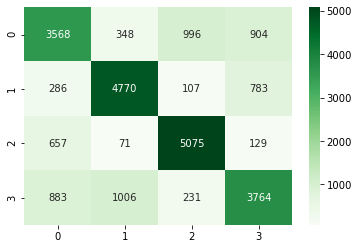

In [34]:
sns.heatmap(heatmapDf, cmap="Greens", annot=True, fmt="d")

Выше представлен $heatmap$, на котором по горизонтали отмечены реальные значения класса, а по вертикали - предсказанные значения класса. 

In [35]:
mistakes = []
for i in range(4):
    wrong = 0
    for j in range(4):
        if i == j: continue
        wrong += values[i][j]
    mistakes.append((i, wrong))

In [36]:
sorted(mistakes, key = lambda x: x[1], reverse = True)

[(0, 2248), (3, 2120), (1, 1176), (2, 857)]

Как мы можем заметить, при предсказании нулевого класса было сделано больше всего ошибок.  
Выходит, модели при обучении стоит больше внимания уделять нулевому классу. Однако, чтобы не переобучить модель, давайте разделим все объекты класса на несколько кластеров, выделим наиболее проблемные из них и уже на них будем обращать повышенное внимание при обучении.

In [37]:
wcss = []

consider = X_train[X_train['bins'] == 0]

for i in tqdm(range(1, 11)):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=10000, n_init=10, random_state=0)
    kmeans.fit(consider)
    wcss.append(kmeans.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]


Методом локтя найдём оптимальное количество кластеров.

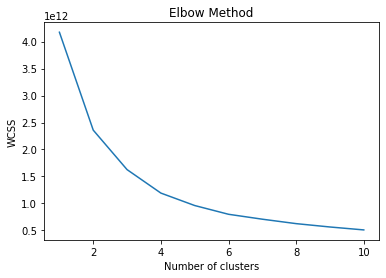

In [38]:
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [41]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=10000, n_init=10, random_state=0)
kmeans.fit(to_work)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [42]:
vals = kmeans.predict(to_work)
cluster_data = []
for i in list(set(vals)):
    cluster_data.append(Counter(predict[true_vals == 0][vals == i]))

In [43]:
for idx, element in enumerate(cluster_data):
    correct = element[0]
    incorrect = sum([element[i] for i in range(1, 4)])
    print('Ошибка в {} кластере = {}%, размер которого = {}, некорректных предсказаний = {}'.format(idx, round(100*incorrect/(incorrect + correct), 2), incorrect + correct, incorrect))

Ошибка в 0 кластере = 44.38%, размер которого = 329, некорректных предсказаний = 146
Ошибка в 1 кластере = 40.2%, размер которого = 2127, некорректных предсказаний = 855
Ошибка в 2 кластере = 29.7%, размер которого = 1404, некорректных предсказаний = 417
Ошибка в 3 кластере = 42.43%, размер которого = 1956, некорректных предсказаний = 830


Создадим список, в котором будем хранить важность точек данных при обучении.

In [44]:
importance = []
for i in tqdm(X_train.index):
    if X_train.loc[i:i, 'bins'].values == 0:
        temp_cluster = kmeans.predict(X_train.loc[i:i])
        if temp_cluster == 1 or temp_cluster == 3:
            importance.append(1.1)
            continue
    importance.append(1)

100%|██████████████████████████████████████████████████████████████████████████| 23578/23578 [00:14<00:00, 1623.11it/s]


Для удобства, воспользуемся $Pool$ - специальным *catboost* классом для датасетов.

In [45]:
train_data = Pool(
    data = X_train.loc[:, 'mean':],
    label = y_train,
    weight = importance,
    cat_features = cat_features
)
valid_data = Pool(
    data = X_valid.loc[:, 'mean':],
    label = y_valid,
    cat_features = cat_features
)

Снова обучим модель и убедимся, что результат на *eval_set* улучшился.

In [46]:
cat.fit(train_data, eval_set = valid_data)

0:	learn: 0.4978509	test: 0.4941667	best: 0.4941667 (0)	total: 220ms	remaining: 7m 19s
1:	learn: 0.5071937	test: 0.5086667	best: 0.5086667 (1)	total: 420ms	remaining: 6m 59s
2:	learn: 0.5104455	test: 0.5100000	best: 0.5100000 (2)	total: 688ms	remaining: 7m 38s
3:	learn: 0.5109583	test: 0.5086667	best: 0.5100000 (2)	total: 917ms	remaining: 7m 37s
4:	learn: 0.5134348	test: 0.5120000	best: 0.5120000 (4)	total: 1.26s	remaining: 8m 22s
5:	learn: 0.5188754	test: 0.5156667	best: 0.5156667 (5)	total: 1.48s	remaining: 8m 10s
6:	learn: 0.5247162	test: 0.5265000	best: 0.5265000 (6)	total: 1.75s	remaining: 8m 17s
7:	learn: 0.5247245	test: 0.5240000	best: 0.5265000 (6)	total: 1.95s	remaining: 8m 6s
8:	learn: 0.5253332	test: 0.5228333	best: 0.5265000 (6)	total: 2.21s	remaining: 8m 10s
9:	learn: 0.5263088	test: 0.5281667	best: 0.5281667 (9)	total: 2.42s	remaining: 8m
10:	learn: 0.5277971	test: 0.5283333	best: 0.5283333 (10)	total: 2.67s	remaining: 8m 3s
11:	learn: 0.5299233	test: 0.5281667	best: 0.52

93:	learn: 0.5884401	test: 0.5793333	best: 0.5793333 (93)	total: 22.9s	remaining: 7m 45s
94:	learn: 0.5886652	test: 0.5790000	best: 0.5793333 (93)	total: 23.2s	remaining: 7m 44s
95:	learn: 0.5883400	test: 0.5790000	best: 0.5793333 (93)	total: 23.4s	remaining: 7m 43s
96:	learn: 0.5892197	test: 0.5785000	best: 0.5793333 (93)	total: 23.6s	remaining: 7m 43s
97:	learn: 0.5896574	test: 0.5796667	best: 0.5796667 (97)	total: 23.8s	remaining: 7m 41s
98:	learn: 0.5901744	test: 0.5795000	best: 0.5796667 (97)	total: 24s	remaining: 7m 41s
99:	learn: 0.5908539	test: 0.5785000	best: 0.5796667 (97)	total: 24.2s	remaining: 7m 40s
100:	learn: 0.5909123	test: 0.5788333	best: 0.5796667 (97)	total: 24.4s	remaining: 7m 39s
101:	learn: 0.5911708	test: 0.5788333	best: 0.5796667 (97)	total: 24.6s	remaining: 7m 38s
102:	learn: 0.5917086	test: 0.5808333	best: 0.5808333 (102)	total: 24.9s	remaining: 7m 38s
103:	learn: 0.5916252	test: 0.5795000	best: 0.5808333 (102)	total: 25.1s	remaining: 7m 36s
104:	learn: 0.591

184:	learn: 0.6091519	test: 0.5951667	best: 0.5958333 (182)	total: 42.3s	remaining: 6m 54s
185:	learn: 0.6094854	test: 0.5955000	best: 0.5958333 (182)	total: 42.5s	remaining: 6m 54s
186:	learn: 0.6090435	test: 0.5955000	best: 0.5958333 (182)	total: 42.7s	remaining: 6m 54s
187:	learn: 0.6090894	test: 0.5958333	best: 0.5958333 (182)	total: 42.9s	remaining: 6m 53s
188:	learn: 0.6096355	test: 0.5965000	best: 0.5965000 (188)	total: 43.1s	remaining: 6m 53s
189:	learn: 0.6095563	test: 0.5966667	best: 0.5966667 (189)	total: 43.3s	remaining: 6m 52s
190:	learn: 0.6096230	test: 0.5951667	best: 0.5966667 (189)	total: 43.6s	remaining: 6m 52s
191:	learn: 0.6097439	test: 0.5955000	best: 0.5966667 (189)	total: 43.7s	remaining: 6m 51s
192:	learn: 0.6098731	test: 0.5958333	best: 0.5966667 (189)	total: 44s	remaining: 6m 51s
193:	learn: 0.6099565	test: 0.5968333	best: 0.5968333 (193)	total: 44.1s	remaining: 6m 51s
194:	learn: 0.6101816	test: 0.5975000	best: 0.5975000 (194)	total: 44.4s	remaining: 6m 50s
1

276:	learn: 0.6235434	test: 0.6048333	best: 0.6056667 (256)	total: 1m 2s	remaining: 6m 26s
277:	learn: 0.6235893	test: 0.6050000	best: 0.6056667 (256)	total: 1m 2s	remaining: 6m 25s
278:	learn: 0.6239687	test: 0.6045000	best: 0.6056667 (256)	total: 1m 2s	remaining: 6m 25s
279:	learn: 0.6236977	test: 0.6050000	best: 0.6056667 (256)	total: 1m 2s	remaining: 6m 25s
280:	learn: 0.6241730	test: 0.6055000	best: 0.6056667 (256)	total: 1m 2s	remaining: 6m 24s
281:	learn: 0.6241354	test: 0.6063333	best: 0.6063333 (281)	total: 1m 3s	remaining: 6m 24s
282:	learn: 0.6243397	test: 0.6055000	best: 0.6063333 (281)	total: 1m 3s	remaining: 6m 24s
283:	learn: 0.6246024	test: 0.6058333	best: 0.6063333 (281)	total: 1m 3s	remaining: 6m 23s
284:	learn: 0.6252277	test: 0.6060000	best: 0.6063333 (281)	total: 1m 3s	remaining: 6m 23s
285:	learn: 0.6256947	test: 0.6068333	best: 0.6068333 (285)	total: 1m 3s	remaining: 6m 23s
286:	learn: 0.6256530	test: 0.6068333	best: 0.6068333 (285)	total: 1m 4s	remaining: 6m 23s

366:	learn: 0.6362549	test: 0.6093333	best: 0.6118333 (332)	total: 1m 21s	remaining: 6m 1s
367:	learn: 0.6363091	test: 0.6098333	best: 0.6118333 (332)	total: 1m 21s	remaining: 6m
368:	learn: 0.6363466	test: 0.6103333	best: 0.6118333 (332)	total: 1m 21s	remaining: 6m
369:	learn: 0.6362257	test: 0.6098333	best: 0.6118333 (332)	total: 1m 21s	remaining: 6m
370:	learn: 0.6362715	test: 0.6098333	best: 0.6118333 (332)	total: 1m 22s	remaining: 6m
371:	learn: 0.6364341	test: 0.6098333	best: 0.6118333 (332)	total: 1m 22s	remaining: 6m
372:	learn: 0.6363549	test: 0.6103333	best: 0.6118333 (332)	total: 1m 22s	remaining: 6m
373:	learn: 0.6368302	test: 0.6100000	best: 0.6118333 (332)	total: 1m 22s	remaining: 5m 59s
374:	learn: 0.6367885	test: 0.6100000	best: 0.6118333 (332)	total: 1m 22s	remaining: 5m 59s
375:	learn: 0.6370428	test: 0.6100000	best: 0.6118333 (332)	total: 1m 23s	remaining: 5m 59s
376:	learn: 0.6373805	test: 0.6105000	best: 0.6118333 (332)	total: 1m 23s	remaining: 5m 58s
377:	learn: 0

456:	learn: 0.6475405	test: 0.6140000	best: 0.6155000 (438)	total: 1m 40s	remaining: 5m 40s
457:	learn: 0.6477531	test: 0.6143333	best: 0.6155000 (438)	total: 1m 41s	remaining: 5m 40s
458:	learn: 0.6477948	test: 0.6140000	best: 0.6155000 (438)	total: 1m 41s	remaining: 5m 40s
459:	learn: 0.6477990	test: 0.6140000	best: 0.6155000 (438)	total: 1m 41s	remaining: 5m 39s
460:	learn: 0.6480282	test: 0.6141667	best: 0.6155000 (438)	total: 1m 41s	remaining: 5m 39s
461:	learn: 0.6481158	test: 0.6141667	best: 0.6155000 (438)	total: 1m 41s	remaining: 5m 39s
462:	learn: 0.6483368	test: 0.6140000	best: 0.6155000 (438)	total: 1m 42s	remaining: 5m 39s
463:	learn: 0.6484994	test: 0.6146667	best: 0.6155000 (438)	total: 1m 42s	remaining: 5m 38s
464:	learn: 0.6484868	test: 0.6141667	best: 0.6155000 (438)	total: 1m 42s	remaining: 5m 38s
465:	learn: 0.6483159	test: 0.6141667	best: 0.6155000 (438)	total: 1m 42s	remaining: 5m 38s
466:	learn: 0.6485410	test: 0.6140000	best: 0.6155000 (438)	total: 1m 43s	remain

546:	learn: 0.6563330	test: 0.6163333	best: 0.6166667 (545)	total: 2m	remaining: 5m 19s
547:	learn: 0.6560495	test: 0.6168333	best: 0.6168333 (547)	total: 2m	remaining: 5m 19s
548:	learn: 0.6560954	test: 0.6168333	best: 0.6168333 (547)	total: 2m	remaining: 5m 19s
549:	learn: 0.6561787	test: 0.6161667	best: 0.6168333 (547)	total: 2m	remaining: 5m 18s
550:	learn: 0.6564372	test: 0.6166667	best: 0.6168333 (547)	total: 2m 1s	remaining: 5m 18s
551:	learn: 0.6567374	test: 0.6171667	best: 0.6171667 (551)	total: 2m 1s	remaining: 5m 18s
552:	learn: 0.6570084	test: 0.6170000	best: 0.6171667 (551)	total: 2m 1s	remaining: 5m 18s
553:	learn: 0.6577380	test: 0.6171667	best: 0.6171667 (551)	total: 2m 1s	remaining: 5m 17s
554:	learn: 0.6573461	test: 0.6170000	best: 0.6171667 (551)	total: 2m 2s	remaining: 5m 17s
555:	learn: 0.6572085	test: 0.6165000	best: 0.6171667 (551)	total: 2m 2s	remaining: 5m 17s
556:	learn: 0.6574670	test: 0.6163333	best: 0.6171667 (551)	total: 2m 2s	remaining: 5m 17s
557:	learn:

636:	learn: 0.6659135	test: 0.6183333	best: 0.6195000 (632)	total: 2m 23s	remaining: 5m 7s
637:	learn: 0.6656675	test: 0.6183333	best: 0.6195000 (632)	total: 2m 24s	remaining: 5m 7s
638:	learn: 0.6658676	test: 0.6188333	best: 0.6195000 (632)	total: 2m 24s	remaining: 5m 7s
639:	learn: 0.6660802	test: 0.6185000	best: 0.6195000 (632)	total: 2m 24s	remaining: 5m 7s
640:	learn: 0.6664763	test: 0.6178333	best: 0.6195000 (632)	total: 2m 24s	remaining: 5m 6s
641:	learn: 0.6665513	test: 0.6173333	best: 0.6195000 (632)	total: 2m 24s	remaining: 5m 6s
642:	learn: 0.6664221	test: 0.6181667	best: 0.6195000 (632)	total: 2m 25s	remaining: 5m 6s
643:	learn: 0.6665597	test: 0.6175000	best: 0.6195000 (632)	total: 2m 25s	remaining: 5m 6s
644:	learn: 0.6665555	test: 0.6176667	best: 0.6195000 (632)	total: 2m 25s	remaining: 5m 6s
645:	learn: 0.6668432	test: 0.6181667	best: 0.6195000 (632)	total: 2m 25s	remaining: 5m 5s
646:	learn: 0.6669766	test: 0.6180000	best: 0.6195000 (632)	total: 2m 26s	remaining: 5m 5s

726:	learn: 0.6734553	test: 0.6198333	best: 0.6220000 (680)	total: 2m 46s	remaining: 4m 51s
727:	learn: 0.6731134	test: 0.6203333	best: 0.6220000 (680)	total: 2m 46s	remaining: 4m 51s
728:	learn: 0.6730759	test: 0.6205000	best: 0.6220000 (680)	total: 2m 47s	remaining: 4m 51s
729:	learn: 0.6729967	test: 0.6201667	best: 0.6220000 (680)	total: 2m 47s	remaining: 4m 51s
730:	learn: 0.6733344	test: 0.6210000	best: 0.6220000 (680)	total: 2m 47s	remaining: 4m 51s
731:	learn: 0.6734177	test: 0.6208333	best: 0.6220000 (680)	total: 2m 48s	remaining: 4m 51s
732:	learn: 0.6735136	test: 0.6201667	best: 0.6220000 (680)	total: 2m 48s	remaining: 4m 51s
733:	learn: 0.6735887	test: 0.6201667	best: 0.6220000 (680)	total: 2m 48s	remaining: 4m 50s
734:	learn: 0.6735053	test: 0.6200000	best: 0.6220000 (680)	total: 2m 48s	remaining: 4m 50s
735:	learn: 0.6739555	test: 0.6206667	best: 0.6220000 (680)	total: 2m 48s	remaining: 4m 50s
736:	learn: 0.6739847	test: 0.6201667	best: 0.6220000 (680)	total: 2m 49s	remain

816:	learn: 0.6808220	test: 0.6195000	best: 0.6220000 (680)	total: 3m 9s	remaining: 4m 34s
817:	learn: 0.6808261	test: 0.6198333	best: 0.6220000 (680)	total: 3m 9s	remaining: 4m 34s
818:	learn: 0.6809554	test: 0.6203333	best: 0.6220000 (680)	total: 3m 9s	remaining: 4m 33s
819:	learn: 0.6807761	test: 0.6201667	best: 0.6220000 (680)	total: 3m 10s	remaining: 4m 33s
820:	learn: 0.6813306	test: 0.6201667	best: 0.6220000 (680)	total: 3m 10s	remaining: 4m 33s
821:	learn: 0.6809887	test: 0.6206667	best: 0.6220000 (680)	total: 3m 10s	remaining: 4m 33s
822:	learn: 0.6810721	test: 0.6208333	best: 0.6220000 (680)	total: 3m 10s	remaining: 4m 33s
823:	learn: 0.6811638	test: 0.6208333	best: 0.6220000 (680)	total: 3m 11s	remaining: 4m 32s
824:	learn: 0.6815182	test: 0.6203333	best: 0.6220000 (680)	total: 3m 11s	remaining: 4m 32s
825:	learn: 0.6814348	test: 0.6201667	best: 0.6220000 (680)	total: 3m 11s	remaining: 4m 32s
826:	learn: 0.6812514	test: 0.6205000	best: 0.6220000 (680)	total: 3m 11s	remaining

906:	learn: 0.6863001	test: 0.6213333	best: 0.6220000 (680)	total: 3m 31s	remaining: 4m 15s
907:	learn: 0.6862542	test: 0.6218333	best: 0.6220000 (680)	total: 3m 31s	remaining: 4m 14s
908:	learn: 0.6864002	test: 0.6216667	best: 0.6220000 (680)	total: 3m 32s	remaining: 4m 14s
909:	learn: 0.6864002	test: 0.6216667	best: 0.6220000 (680)	total: 3m 32s	remaining: 4m 14s
910:	learn: 0.6862125	test: 0.6215000	best: 0.6220000 (680)	total: 3m 32s	remaining: 4m 14s
911:	learn: 0.6862292	test: 0.6211667	best: 0.6220000 (680)	total: 3m 33s	remaining: 4m 14s
912:	learn: 0.6865336	test: 0.6215000	best: 0.6220000 (680)	total: 3m 33s	remaining: 4m 13s
913:	learn: 0.6867045	test: 0.6213333	best: 0.6220000 (680)	total: 3m 33s	remaining: 4m 13s
914:	learn: 0.6871714	test: 0.6216667	best: 0.6220000 (680)	total: 3m 33s	remaining: 4m 13s
915:	learn: 0.6868754	test: 0.6218333	best: 0.6220000 (680)	total: 3m 34s	remaining: 4m 13s
916:	learn: 0.6872131	test: 0.6216667	best: 0.6220000 (680)	total: 3m 34s	remain

996:	learn: 0.6913405	test: 0.6236667	best: 0.6240000 (990)	total: 3m 53s	remaining: 3m 54s
997:	learn: 0.6915156	test: 0.6240000	best: 0.6240000 (990)	total: 3m 53s	remaining: 3m 54s
998:	learn: 0.6915573	test: 0.6236667	best: 0.6240000 (990)	total: 3m 53s	remaining: 3m 54s
999:	learn: 0.6916782	test: 0.6233333	best: 0.6240000 (990)	total: 3m 53s	remaining: 3m 53s
1000:	learn: 0.6917657	test: 0.6231667	best: 0.6240000 (990)	total: 3m 54s	remaining: 3m 53s
1001:	learn: 0.6918032	test: 0.6233333	best: 0.6240000 (990)	total: 3m 54s	remaining: 3m 53s
1002:	learn: 0.6919408	test: 0.6235000	best: 0.6240000 (990)	total: 3m 54s	remaining: 3m 53s
1003:	learn: 0.6920701	test: 0.6231667	best: 0.6240000 (990)	total: 3m 54s	remaining: 3m 52s
1004:	learn: 0.6923202	test: 0.6230000	best: 0.6240000 (990)	total: 3m 55s	remaining: 3m 52s
1005:	learn: 0.6922076	test: 0.6228333	best: 0.6240000 (990)	total: 3m 55s	remaining: 3m 52s
1006:	learn: 0.6922785	test: 0.6226667	best: 0.6240000 (990)	total: 3m 55s

1086:	learn: 0.6966769	test: 0.6218333	best: 0.6240000 (990)	total: 4m 12s	remaining: 3m 31s
1087:	learn: 0.6971021	test: 0.6223333	best: 0.6240000 (990)	total: 4m 12s	remaining: 3m 31s
1088:	learn: 0.6971021	test: 0.6221667	best: 0.6240000 (990)	total: 4m 12s	remaining: 3m 31s
1089:	learn: 0.6972689	test: 0.6221667	best: 0.6240000 (990)	total: 4m 12s	remaining: 3m 31s
1090:	learn: 0.6973981	test: 0.6223333	best: 0.6240000 (990)	total: 4m 13s	remaining: 3m 30s
1091:	learn: 0.6974023	test: 0.6225000	best: 0.6240000 (990)	total: 4m 13s	remaining: 3m 30s
1092:	learn: 0.6974982	test: 0.6230000	best: 0.6240000 (990)	total: 4m 13s	remaining: 3m 30s
1093:	learn: 0.6974856	test: 0.6228333	best: 0.6240000 (990)	total: 4m 13s	remaining: 3m 30s
1094:	learn: 0.6976232	test: 0.6230000	best: 0.6240000 (990)	total: 4m 14s	remaining: 3m 29s
1095:	learn: 0.6977400	test: 0.6230000	best: 0.6240000 (990)	total: 4m 14s	remaining: 3m 29s
1096:	learn: 0.6978817	test: 0.6228333	best: 0.6240000 (990)	total: 4m

1174:	learn: 0.7018256	test: 0.6238333	best: 0.6250000 (1162)	total: 4m 30s	remaining: 3m 10s
1175:	learn: 0.7018590	test: 0.6240000	best: 0.6250000 (1162)	total: 4m 30s	remaining: 3m 9s
1176:	learn: 0.7018590	test: 0.6236667	best: 0.6250000 (1162)	total: 4m 31s	remaining: 3m 9s
1177:	learn: 0.7020716	test: 0.6236667	best: 0.6250000 (1162)	total: 4m 31s	remaining: 3m 9s
1178:	learn: 0.7022801	test: 0.6236667	best: 0.6250000 (1162)	total: 4m 31s	remaining: 3m 9s
1179:	learn: 0.7021550	test: 0.6236667	best: 0.6250000 (1162)	total: 4m 31s	remaining: 3m 8s
1180:	learn: 0.7020382	test: 0.6231667	best: 0.6250000 (1162)	total: 4m 31s	remaining: 3m 8s
1181:	learn: 0.7018965	test: 0.6236667	best: 0.6250000 (1162)	total: 4m 32s	remaining: 3m 8s
1182:	learn: 0.7019799	test: 0.6236667	best: 0.6250000 (1162)	total: 4m 32s	remaining: 3m 8s
1183:	learn: 0.7021508	test: 0.6240000	best: 0.6250000 (1162)	total: 4m 32s	remaining: 3m 7s
1184:	learn: 0.7022384	test: 0.6241667	best: 0.6250000 (1162)	total: 

1262:	learn: 0.7060697	test: 0.6243333	best: 0.6251667 (1194)	total: 4m 49s	remaining: 2m 49s
1263:	learn: 0.7060155	test: 0.6243333	best: 0.6251667 (1194)	total: 4m 49s	remaining: 2m 48s
1264:	learn: 0.7063574	test: 0.6240000	best: 0.6251667 (1194)	total: 4m 50s	remaining: 2m 48s
1265:	learn: 0.7064449	test: 0.6238333	best: 0.6251667 (1194)	total: 4m 50s	remaining: 2m 48s
1266:	learn: 0.7064950	test: 0.6236667	best: 0.6251667 (1194)	total: 4m 50s	remaining: 2m 48s
1267:	learn: 0.7065825	test: 0.6241667	best: 0.6251667 (1194)	total: 4m 50s	remaining: 2m 47s
1268:	learn: 0.7066617	test: 0.6241667	best: 0.6251667 (1194)	total: 4m 50s	remaining: 2m 47s
1269:	learn: 0.7067993	test: 0.6238333	best: 0.6251667 (1194)	total: 4m 51s	remaining: 2m 47s
1270:	learn: 0.7067117	test: 0.6235000	best: 0.6251667 (1194)	total: 4m 51s	remaining: 2m 47s
1271:	learn: 0.7069661	test: 0.6235000	best: 0.6251667 (1194)	total: 4m 51s	remaining: 2m 46s
1272:	learn: 0.7073121	test: 0.6240000	best: 0.6251667 (1194

1350:	learn: 0.7118522	test: 0.6246667	best: 0.6251667 (1194)	total: 5m 8s	remaining: 2m 28s
1351:	learn: 0.7119856	test: 0.6245000	best: 0.6251667 (1194)	total: 5m 8s	remaining: 2m 27s
1352:	learn: 0.7121982	test: 0.6245000	best: 0.6251667 (1194)	total: 5m 8s	remaining: 2m 27s
1353:	learn: 0.7121565	test: 0.6243333	best: 0.6251667 (1194)	total: 5m 9s	remaining: 2m 27s
1354:	learn: 0.7120773	test: 0.6241667	best: 0.6251667 (1194)	total: 5m 9s	remaining: 2m 27s
1355:	learn: 0.7121982	test: 0.6243333	best: 0.6251667 (1194)	total: 5m 9s	remaining: 2m 27s
1356:	learn: 0.7119814	test: 0.6238333	best: 0.6251667 (1194)	total: 5m 10s	remaining: 2m 27s
1357:	learn: 0.7117730	test: 0.6240000	best: 0.6251667 (1194)	total: 5m 10s	remaining: 2m 26s
1358:	learn: 0.7121190	test: 0.6238333	best: 0.6251667 (1194)	total: 5m 10s	remaining: 2m 26s
1359:	learn: 0.7124567	test: 0.6238333	best: 0.6251667 (1194)	total: 5m 11s	remaining: 2m 26s
1360:	learn: 0.7124567	test: 0.6238333	best: 0.6251667 (1194)	tota

1438:	learn: 0.7164590	test: 0.6255000	best: 0.6260000 (1434)	total: 5m 28s	remaining: 2m 7s
1439:	learn: 0.7165424	test: 0.6253333	best: 0.6260000 (1434)	total: 5m 28s	remaining: 2m 7s
1440:	learn: 0.7167925	test: 0.6253333	best: 0.6260000 (1434)	total: 5m 28s	remaining: 2m 7s
1441:	learn: 0.7169217	test: 0.6256667	best: 0.6260000 (1434)	total: 5m 28s	remaining: 2m 7s
1442:	learn: 0.7168008	test: 0.6256667	best: 0.6260000 (1434)	total: 5m 28s	remaining: 2m 6s
1443:	learn: 0.7168884	test: 0.6253333	best: 0.6260000 (1434)	total: 5m 29s	remaining: 2m 6s
1444:	learn: 0.7168801	test: 0.6250000	best: 0.6260000 (1434)	total: 5m 29s	remaining: 2m 6s
1445:	learn: 0.7167508	test: 0.6248333	best: 0.6260000 (1434)	total: 5m 29s	remaining: 2m 6s
1446:	learn: 0.7168717	test: 0.6251667	best: 0.6260000 (1434)	total: 5m 29s	remaining: 2m 6s
1447:	learn: 0.7169968	test: 0.6251667	best: 0.6260000 (1434)	total: 5m 29s	remaining: 2m 5s
1448:	learn: 0.7170010	test: 0.6251667	best: 0.6260000 (1434)	total: 5

1526:	learn: 0.7213326	test: 0.6248333	best: 0.6260000 (1434)	total: 5m 46s	remaining: 1m 47s
1527:	learn: 0.7213451	test: 0.6248333	best: 0.6260000 (1434)	total: 5m 46s	remaining: 1m 47s
1528:	learn: 0.7213826	test: 0.6248333	best: 0.6260000 (1434)	total: 5m 47s	remaining: 1m 46s
1529:	learn: 0.7212492	test: 0.6250000	best: 0.6260000 (1434)	total: 5m 47s	remaining: 1m 46s
1530:	learn: 0.7212534	test: 0.6251667	best: 0.6260000 (1434)	total: 5m 47s	remaining: 1m 46s
1531:	learn: 0.7215119	test: 0.6246667	best: 0.6260000 (1434)	total: 5m 47s	remaining: 1m 46s
1532:	learn: 0.7213284	test: 0.6246667	best: 0.6260000 (1434)	total: 5m 48s	remaining: 1m 46s
1533:	learn: 0.7214994	test: 0.6243333	best: 0.6260000 (1434)	total: 5m 48s	remaining: 1m 45s
1534:	learn: 0.7214994	test: 0.6240000	best: 0.6260000 (1434)	total: 5m 48s	remaining: 1m 45s
1535:	learn: 0.7215452	test: 0.6240000	best: 0.6260000 (1434)	total: 5m 48s	remaining: 1m 45s
1536:	learn: 0.7217161	test: 0.6241667	best: 0.6260000 (1434

1614:	learn: 0.7239216	test: 0.6245000	best: 0.6260000 (1434)	total: 6m 5s	remaining: 1m 27s
1615:	learn: 0.7241342	test: 0.6243333	best: 0.6260000 (1434)	total: 6m 5s	remaining: 1m 26s
1616:	learn: 0.7243010	test: 0.6248333	best: 0.6260000 (1434)	total: 6m 6s	remaining: 1m 26s
1617:	learn: 0.7241717	test: 0.6246667	best: 0.6260000 (1434)	total: 6m 6s	remaining: 1m 26s
1618:	learn: 0.7242509	test: 0.6246667	best: 0.6260000 (1434)	total: 6m 6s	remaining: 1m 26s
1619:	learn: 0.7241259	test: 0.6250000	best: 0.6260000 (1434)	total: 6m 6s	remaining: 1m 26s
1620:	learn: 0.7242509	test: 0.6248333	best: 0.6260000 (1434)	total: 6m 6s	remaining: 1m 25s
1621:	learn: 0.7244135	test: 0.6246667	best: 0.6260000 (1434)	total: 6m 7s	remaining: 1m 25s
1622:	learn: 0.7244135	test: 0.6245000	best: 0.6260000 (1434)	total: 6m 7s	remaining: 1m 25s
1623:	learn: 0.7245761	test: 0.6240000	best: 0.6260000 (1434)	total: 6m 7s	remaining: 1m 25s
1624:	learn: 0.7245344	test: 0.6240000	best: 0.6260000 (1434)	total: 6

1702:	learn: 0.7287910	test: 0.6258333	best: 0.6265000 (1673)	total: 6m 24s	remaining: 1m 7s
1703:	learn: 0.7288744	test: 0.6255000	best: 0.6265000 (1673)	total: 6m 24s	remaining: 1m 6s
1704:	learn: 0.7288786	test: 0.6256667	best: 0.6265000 (1673)	total: 6m 25s	remaining: 1m 6s
1705:	learn: 0.7289161	test: 0.6256667	best: 0.6265000 (1673)	total: 6m 25s	remaining: 1m 6s
1706:	learn: 0.7289995	test: 0.6253333	best: 0.6265000 (1673)	total: 6m 25s	remaining: 1m 6s
1707:	learn: 0.7290328	test: 0.6255000	best: 0.6265000 (1673)	total: 6m 25s	remaining: 1m 5s
1708:	learn: 0.7290787	test: 0.6255000	best: 0.6265000 (1673)	total: 6m 26s	remaining: 1m 5s
1709:	learn: 0.7290829	test: 0.6253333	best: 0.6265000 (1673)	total: 6m 26s	remaining: 1m 5s
1710:	learn: 0.7290453	test: 0.6258333	best: 0.6265000 (1673)	total: 6m 26s	remaining: 1m 5s
1711:	learn: 0.7291621	test: 0.6255000	best: 0.6265000 (1673)	total: 6m 26s	remaining: 1m 5s
1712:	learn: 0.7292038	test: 0.6253333	best: 0.6265000 (1673)	total: 6

1792:	learn: 0.7327891	test: 0.6240000	best: 0.6265000 (1673)	total: 6m 44s	remaining: 46.7s
1793:	learn: 0.7329225	test: 0.6240000	best: 0.6265000 (1673)	total: 6m 44s	remaining: 46.5s
1794:	learn: 0.7330893	test: 0.6238333	best: 0.6265000 (1673)	total: 6m 45s	remaining: 46.3s
1795:	learn: 0.7332144	test: 0.6236667	best: 0.6265000 (1673)	total: 6m 45s	remaining: 46s
1796:	learn: 0.7327516	test: 0.6236667	best: 0.6265000 (1673)	total: 6m 45s	remaining: 45.8s
1797:	learn: 0.7327933	test: 0.6233333	best: 0.6265000 (1673)	total: 6m 45s	remaining: 45.6s
1798:	learn: 0.7330893	test: 0.6233333	best: 0.6265000 (1673)	total: 6m 45s	remaining: 45.4s
1799:	learn: 0.7331268	test: 0.6235000	best: 0.6265000 (1673)	total: 6m 46s	remaining: 45.1s
1800:	learn: 0.7330768	test: 0.6235000	best: 0.6265000 (1673)	total: 6m 46s	remaining: 44.9s
1801:	learn: 0.7333770	test: 0.6236667	best: 0.6265000 (1673)	total: 6m 46s	remaining: 44.7s
1802:	learn: 0.7331977	test: 0.6238333	best: 0.6265000 (1673)	total: 6m 

1882:	learn: 0.7369165	test: 0.6243333	best: 0.6265000 (1673)	total: 7m 6s	remaining: 26.5s
1883:	learn: 0.7367539	test: 0.6243333	best: 0.6265000 (1673)	total: 7m 6s	remaining: 26.3s
1884:	learn: 0.7365329	test: 0.6246667	best: 0.6265000 (1673)	total: 7m 6s	remaining: 26s
1885:	learn: 0.7368248	test: 0.6248333	best: 0.6265000 (1673)	total: 7m 7s	remaining: 25.8s
1886:	learn: 0.7368665	test: 0.6248333	best: 0.6265000 (1673)	total: 7m 7s	remaining: 25.6s
1887:	learn: 0.7366622	test: 0.6246667	best: 0.6265000 (1673)	total: 7m 7s	remaining: 25.4s
1888:	learn: 0.7365746	test: 0.6248333	best: 0.6265000 (1673)	total: 7m 7s	remaining: 25.1s
1889:	learn: 0.7368248	test: 0.6248333	best: 0.6265000 (1673)	total: 7m 7s	remaining: 24.9s
1890:	learn: 0.7370416	test: 0.6243333	best: 0.6265000 (1673)	total: 7m 8s	remaining: 24.7s
1891:	learn: 0.7371291	test: 0.6243333	best: 0.6265000 (1673)	total: 7m 8s	remaining: 24.5s
1892:	learn: 0.7372167	test: 0.6245000	best: 0.6265000 (1673)	total: 7m 8s	remaini

1971:	learn: 0.7404268	test: 0.6240000	best: 0.6265000 (1673)	total: 7m 26s	remaining: 6.34s
1972:	learn: 0.7406436	test: 0.6241667	best: 0.6265000 (1673)	total: 7m 26s	remaining: 6.11s
1973:	learn: 0.7404810	test: 0.6241667	best: 0.6265000 (1673)	total: 7m 26s	remaining: 5.88s
1974:	learn: 0.7406478	test: 0.6241667	best: 0.6265000 (1673)	total: 7m 27s	remaining: 5.66s
1975:	learn: 0.7406478	test: 0.6241667	best: 0.6265000 (1673)	total: 7m 27s	remaining: 5.43s
1976:	learn: 0.7406853	test: 0.6236667	best: 0.6265000 (1673)	total: 7m 27s	remaining: 5.21s
1977:	learn: 0.7406895	test: 0.6236667	best: 0.6265000 (1673)	total: 7m 27s	remaining: 4.98s
1978:	learn: 0.7406895	test: 0.6233333	best: 0.6265000 (1673)	total: 7m 27s	remaining: 4.75s
1979:	learn: 0.7408604	test: 0.6233333	best: 0.6265000 (1673)	total: 7m 28s	remaining: 4.53s
1980:	learn: 0.7407729	test: 0.6235000	best: 0.6265000 (1673)	total: 7m 28s	remaining: 4.3s
1981:	learn: 0.7409355	test: 0.6235000	best: 0.6265000 (1673)	total: 7m

Теперь подгрузим тестовые данные для того, чтобы сделать предсказание. Проделаем с ними те же самые манипуляции, как и с обучающими данными.

In [47]:
transactions_test=pd.read_csv('data/transactions_test.csv')

test_id=pd.read_csv('data/test.csv')

In [48]:
agg_features_test=transactions_test.groupby('client_id')['amount_rur'].agg(['sum','mean','std','min','max', 'count']).reset_index()

In [49]:
agg_features_test.head()

,client_id,sum,mean,std,min,max,count
0,0,17036.127,19.163247,40.561700,0.065,595.339,889
1,1,34748.964,47.666617,89.489278,0.298,1181.221,729
2,2,51188.069,68.433247,152.093601,0.043,2837.682,748
3,3,47975.203,67.857430,318.651653,0.043,6135.652,707
4,5,20059.100,21.803370,34.258433,0.043,439.902,920


In [50]:
counter_df_test=transactions_test.groupby(['client_id','small_group'])['amount_rur'].count()

In [51]:
cat_counts_test=counter_df_test.reset_index().pivot(index='client_id', columns='small_group',values='amount_rur')

In [52]:
cat_counts_test=cat_counts_test.fillna(0)

In [53]:
cat_counts_test.columns=['small_group_'+str(i) for i in cat_counts_test.columns]

In [54]:
cat_counts_test.head()

,small_group_0,small_group_1,small_group_2,small_group_3,small_group_4,small_group_5,small_group_6,small_group_7,small_group_8,small_group_9,...,small_group_192,small_group_193,small_group_194,small_group_195,small_group_196,small_group_197,small_group_198,small_group_200,small_group_201,small_group_202
client_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,226.0,1.0,36.0,9.0,0.0,0.0,0.0,2.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30.0,326.0,0.0,40.0,56.0,0.0,0.0,0.0,0.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21.0,242.0,1.0,50.0,48.0,4.0,0.0,6.0,1.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,156.0,83.0,48.0,31.0,2.0,0.0,1.0,2.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,16.0,398.0,1.0,23.0,25.0,0.0,0.0,0.0,5.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
test=pd.merge(test_id,agg_features_test,on='client_id')

In [56]:
test=pd.merge(test,cat_counts_test.reset_index(),on='client_id')

In [57]:
test.head()

,client_id,sum,mean,std,min,max,count,small_group_0,small_group_1,small_group_2,...,small_group_192,small_group_193,small_group_194,small_group_195,small_group_196,small_group_197,small_group_198,small_group_200,small_group_201,small_group_202
0,28571,30507.083,42.488974,43.659666,0.078,306.882,718,0.0,278.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,27046,39378.016,38.988135,93.600961,0.043,1469.007,1010,9.0,193.0,68.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13240,50211.127,53.302683,198.583630,1.078,3902.918,942,0.0,227.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,19974,45371.491,53.252924,273.597147,0.432,5865.551,852,42.0,305.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10505,90883.628,81.950972,119.408720,0.043,1921.341,1109,0.0,516.0,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
for column in test.columns[7:]:
    test[column] /= test['count']

In [59]:
test['range_value'] = test['max'] - test['min']
replace = ['sum', 'min', 'max']
for name in replace:
    test[name + '_value'] = test[name].copy()
    del test[name]

In [60]:
for agg in tqdm(aggregable_features):
    for i in classes:
        test[str(agg) + '_dist_' + str(i)] = test[agg].apply(lambda x: (x - aggregated[agg]['mean'][i]) / aggregated[agg]['std'][i])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:57<00:00, 83.53s/it]


In [61]:
transactions_test['trans_date'] %= 7

In [62]:
idx_sum = 0
days = {}
for i in tqdm(list(transactions_test['client_id'].value_counts().items())):
    days[i[0]] = Counter(transactions_test.loc[idx_sum:idx_sum + i[1] - 1, 'trans_date'])
    idx_sum += i[1]

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:10<00:00, 1915.36it/s]


In [63]:
for i in tqdm(range(7)):
    test['purchase_{}'.format(i)] = test['client_id'].apply(lambda x: days[x][i]) / test['count'] 

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 29.43it/s]


In [64]:
for i in tqdm(range(7)):
    test['popular_day_{}'.format(i)] = test['client_id'].apply(lambda x: days[x].most_common()[i][0])

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]


В тесте не было некоторых категорий трат, поэтому для того, чтобы обучить модель, нам нужно объединить пространство признаков и train и test.

In [66]:
common_features=sorted(list(set(X_train.columns).intersection(set(test.columns))))
X_train=X_train[common_features]
X_valid=X_valid[common_features]
test=test[common_features]

In [68]:
cat_features = [list(X_train.columns).index('popular_day_0') + i for i in range(7)]

train_data = Pool(
    data = X_train,
    label = y_train,
    weight = importance,
    cat_features = cat_features
)
valid_data = Pool(
    data = X_valid,
    label = y_valid,
    cat_features = cat_features
)

Обучим catboost на текущих признаках.

In [69]:
cat.fit(train_data, eval_set = valid_data)

0:	learn: 0.4932065	test: 0.4910000	best: 0.4910000 (0)	total: 317ms	remaining: 10m 33s
1:	learn: 0.4995518	test: 0.4970000	best: 0.4970000 (1)	total: 648ms	remaining: 10m 47s
2:	learn: 0.5047298	test: 0.5030000	best: 0.5030000 (2)	total: 1.26s	remaining: 13m 59s
3:	learn: 0.5141352	test: 0.5061667	best: 0.5061667 (3)	total: 1.64s	remaining: 13m 36s
4:	learn: 0.5175955	test: 0.5111667	best: 0.5111667 (4)	total: 2.19s	remaining: 14m 35s
5:	learn: 0.5158945	test: 0.5153333	best: 0.5153333 (5)	total: 2.54s	remaining: 14m 5s
6:	learn: 0.5169534	test: 0.5166667	best: 0.5166667 (6)	total: 3.05s	remaining: 14m 27s
7:	learn: 0.5196716	test: 0.5186667	best: 0.5186667 (7)	total: 3.55s	remaining: 14m 44s
8:	learn: 0.5216186	test: 0.5193333	best: 0.5193333 (8)	total: 4.17s	remaining: 15m 23s
9:	learn: 0.5243577	test: 0.5255000	best: 0.5255000 (9)	total: 4.52s	remaining: 14m 59s
10:	learn: 0.5283558	test: 0.5270000	best: 0.5270000 (10)	total: 4.94s	remaining: 14m 52s
11:	learn: 0.5298941	test: 0.52

92:	learn: 0.5852674	test: 0.5750000	best: 0.5750000 (92)	total: 37.1s	remaining: 12m 41s
93:	learn: 0.5853383	test: 0.5750000	best: 0.5750000 (92)	total: 37.4s	remaining: 12m 38s
94:	learn: 0.5858511	test: 0.5753333	best: 0.5753333 (94)	total: 37.8s	remaining: 12m 37s
95:	learn: 0.5866390	test: 0.5763333	best: 0.5763333 (95)	total: 38.1s	remaining: 12m 35s
96:	learn: 0.5866474	test: 0.5766667	best: 0.5766667 (96)	total: 38.5s	remaining: 12m 35s
97:	learn: 0.5871977	test: 0.5770000	best: 0.5770000 (97)	total: 38.9s	remaining: 12m 34s
98:	learn: 0.5877021	test: 0.5761667	best: 0.5770000 (97)	total: 39.3s	remaining: 12m 35s
99:	learn: 0.5885693	test: 0.5776667	best: 0.5776667 (99)	total: 39.6s	remaining: 12m 32s
100:	learn: 0.5890738	test: 0.5775000	best: 0.5776667 (99)	total: 40s	remaining: 12m 32s
101:	learn: 0.5893823	test: 0.5776667	best: 0.5776667 (99)	total: 40.4s	remaining: 12m 31s
102:	learn: 0.5901369	test: 0.5783333	best: 0.5783333 (102)	total: 40.9s	remaining: 12m 33s
103:	lea

182:	learn: 0.6084473	test: 0.5941667	best: 0.5955000 (181)	total: 1m 13s	remaining: 12m 6s
183:	learn: 0.6088642	test: 0.5948333	best: 0.5955000 (181)	total: 1m 13s	remaining: 12m 5s
184:	learn: 0.6091936	test: 0.5948333	best: 0.5955000 (181)	total: 1m 13s	remaining: 12m 5s
185:	learn: 0.6094062	test: 0.5951667	best: 0.5955000 (181)	total: 1m 14s	remaining: 12m 4s
186:	learn: 0.6092269	test: 0.5955000	best: 0.5955000 (181)	total: 1m 14s	remaining: 12m 5s
187:	learn: 0.6093812	test: 0.5955000	best: 0.5955000 (181)	total: 1m 15s	remaining: 12m 5s
188:	learn: 0.6091769	test: 0.5945000	best: 0.5955000 (181)	total: 1m 15s	remaining: 12m 4s
189:	learn: 0.6095354	test: 0.5936667	best: 0.5955000 (181)	total: 1m 16s	remaining: 12m 5s
190:	learn: 0.6097647	test: 0.5943333	best: 0.5955000 (181)	total: 1m 16s	remaining: 12m 6s
191:	learn: 0.6103734	test: 0.5948333	best: 0.5955000 (181)	total: 1m 17s	remaining: 12m 6s
192:	learn: 0.6104943	test: 0.5955000	best: 0.5955000 (181)	total: 1m 17s	remain

271:	learn: 0.6228139	test: 0.6051667	best: 0.6058333 (263)	total: 1m 48s	remaining: 11m 31s
272:	learn: 0.6232224	test: 0.6046667	best: 0.6058333 (263)	total: 1m 49s	remaining: 11m 31s
273:	learn: 0.6233225	test: 0.6038333	best: 0.6058333 (263)	total: 1m 49s	remaining: 11m 30s
274:	learn: 0.6233975	test: 0.6030000	best: 0.6058333 (263)	total: 1m 50s	remaining: 11m 30s
275:	learn: 0.6237978	test: 0.6030000	best: 0.6058333 (263)	total: 1m 50s	remaining: 11m 30s
276:	learn: 0.6242939	test: 0.6035000	best: 0.6058333 (263)	total: 1m 50s	remaining: 11m 29s
277:	learn: 0.6243981	test: 0.6046667	best: 0.6058333 (263)	total: 1m 51s	remaining: 11m 28s
278:	learn: 0.6251027	test: 0.6035000	best: 0.6058333 (263)	total: 1m 51s	remaining: 11m 28s
279:	learn: 0.6250610	test: 0.6045000	best: 0.6058333 (263)	total: 1m 51s	remaining: 11m 27s
280:	learn: 0.6248442	test: 0.6041667	best: 0.6058333 (263)	total: 1m 52s	remaining: 11m 26s
281:	learn: 0.6256988	test: 0.6055000	best: 0.6058333 (263)	total: 1m 

360:	learn: 0.6377724	test: 0.6093333	best: 0.6096667 (348)	total: 2m 20s	remaining: 10m 39s
361:	learn: 0.6375181	test: 0.6101667	best: 0.6101667 (361)	total: 2m 21s	remaining: 10m 38s
362:	learn: 0.6379558	test: 0.6108333	best: 0.6108333 (362)	total: 2m 21s	remaining: 10m 37s
363:	learn: 0.6382018	test: 0.6106667	best: 0.6108333 (362)	total: 2m 21s	remaining: 10m 36s
364:	learn: 0.6382894	test: 0.6100000	best: 0.6108333 (362)	total: 2m 22s	remaining: 10m 36s
365:	learn: 0.6382894	test: 0.6095000	best: 0.6108333 (362)	total: 2m 22s	remaining: 10m 35s
366:	learn: 0.6383727	test: 0.6103333	best: 0.6108333 (362)	total: 2m 22s	remaining: 10m 35s
367:	learn: 0.6381726	test: 0.6105000	best: 0.6108333 (362)	total: 2m 23s	remaining: 10m 34s
368:	learn: 0.6387688	test: 0.6108333	best: 0.6108333 (362)	total: 2m 23s	remaining: 10m 33s
369:	learn: 0.6386896	test: 0.6113333	best: 0.6113333 (369)	total: 2m 23s	remaining: 10m 33s
370:	learn: 0.6387354	test: 0.6103333	best: 0.6113333 (369)	total: 2m 

449:	learn: 0.6481283	test: 0.6120000	best: 0.6131667 (439)	total: 2m 53s	remaining: 9m 56s
450:	learn: 0.6484160	test: 0.6110000	best: 0.6131667 (439)	total: 2m 53s	remaining: 9m 55s
451:	learn: 0.6477864	test: 0.6108333	best: 0.6131667 (439)	total: 2m 53s	remaining: 9m 55s
452:	learn: 0.6482534	test: 0.6111667	best: 0.6131667 (439)	total: 2m 54s	remaining: 9m 55s
453:	learn: 0.6482617	test: 0.6115000	best: 0.6131667 (439)	total: 2m 54s	remaining: 9m 54s
454:	learn: 0.6485661	test: 0.6111667	best: 0.6131667 (439)	total: 2m 55s	remaining: 9m 54s
455:	learn: 0.6481700	test: 0.6111667	best: 0.6131667 (439)	total: 2m 55s	remaining: 9m 54s
456:	learn: 0.6486161	test: 0.6111667	best: 0.6131667 (439)	total: 2m 55s	remaining: 9m 54s
457:	learn: 0.6484577	test: 0.6106667	best: 0.6131667 (439)	total: 2m 56s	remaining: 9m 53s
458:	learn: 0.6487453	test: 0.6113333	best: 0.6131667 (439)	total: 2m 56s	remaining: 9m 53s
459:	learn: 0.6486953	test: 0.6116667	best: 0.6131667 (439)	total: 2m 57s	remain

539:	learn: 0.6585759	test: 0.6151667	best: 0.6166667 (527)	total: 3m 27s	remaining: 9m 21s
540:	learn: 0.6586551	test: 0.6153333	best: 0.6166667 (527)	total: 3m 28s	remaining: 9m 20s
541:	learn: 0.6585759	test: 0.6156667	best: 0.6166667 (527)	total: 3m 28s	remaining: 9m 20s
542:	learn: 0.6587927	test: 0.6156667	best: 0.6166667 (527)	total: 3m 28s	remaining: 9m 20s
543:	learn: 0.6589136	test: 0.6153333	best: 0.6166667 (527)	total: 3m 29s	remaining: 9m 20s
544:	learn: 0.6584342	test: 0.6150000	best: 0.6166667 (527)	total: 3m 29s	remaining: 9m 19s
545:	learn: 0.6591221	test: 0.6151667	best: 0.6166667 (527)	total: 3m 29s	remaining: 9m 19s
546:	learn: 0.6592096	test: 0.6148333	best: 0.6166667 (527)	total: 3m 30s	remaining: 9m 18s
547:	learn: 0.6593889	test: 0.6146667	best: 0.6166667 (527)	total: 3m 30s	remaining: 9m 18s
548:	learn: 0.6592680	test: 0.6146667	best: 0.6166667 (527)	total: 3m 30s	remaining: 9m 17s
549:	learn: 0.6591054	test: 0.6151667	best: 0.6166667 (527)	total: 3m 31s	remain

629:	learn: 0.6667806	test: 0.6161667	best: 0.6166667 (527)	total: 4m 1s	remaining: 8m 45s
630:	learn: 0.6666972	test: 0.6165000	best: 0.6166667 (527)	total: 4m 1s	remaining: 8m 44s
631:	learn: 0.6667473	test: 0.6165000	best: 0.6166667 (527)	total: 4m 2s	remaining: 8m 44s
632:	learn: 0.6666806	test: 0.6165000	best: 0.6166667 (527)	total: 4m 2s	remaining: 8m 43s
633:	learn: 0.6668140	test: 0.6163333	best: 0.6166667 (527)	total: 4m 2s	remaining: 8m 43s
634:	learn: 0.6670266	test: 0.6166667	best: 0.6166667 (527)	total: 4m 3s	remaining: 8m 42s
635:	learn: 0.6667139	test: 0.6161667	best: 0.6166667 (527)	total: 4m 3s	remaining: 8m 42s
636:	learn: 0.6672350	test: 0.6161667	best: 0.6166667 (527)	total: 4m 3s	remaining: 8m 42s
637:	learn: 0.6670558	test: 0.6165000	best: 0.6166667 (527)	total: 4m 4s	remaining: 8m 41s
638:	learn: 0.6676603	test: 0.6166667	best: 0.6166667 (527)	total: 4m 4s	remaining: 8m 41s
639:	learn: 0.6678271	test: 0.6165000	best: 0.6166667 (527)	total: 4m 5s	remaining: 8m 41s

719:	learn: 0.6732635	test: 0.6165000	best: 0.6190000 (683)	total: 4m 34s	remaining: 8m 8s
720:	learn: 0.6734261	test: 0.6170000	best: 0.6190000 (683)	total: 4m 34s	remaining: 8m 7s
721:	learn: 0.6737679	test: 0.6178333	best: 0.6190000 (683)	total: 4m 35s	remaining: 8m 7s
722:	learn: 0.6738013	test: 0.6175000	best: 0.6190000 (683)	total: 4m 35s	remaining: 8m 7s
723:	learn: 0.6736262	test: 0.6180000	best: 0.6190000 (683)	total: 4m 36s	remaining: 8m 6s
724:	learn: 0.6737888	test: 0.6176667	best: 0.6190000 (683)	total: 4m 36s	remaining: 8m 6s
725:	learn: 0.6738722	test: 0.6175000	best: 0.6190000 (683)	total: 4m 37s	remaining: 8m 6s
726:	learn: 0.6740473	test: 0.6170000	best: 0.6190000 (683)	total: 4m 37s	remaining: 8m 5s
727:	learn: 0.6742182	test: 0.6180000	best: 0.6190000 (683)	total: 4m 37s	remaining: 8m 5s
728:	learn: 0.6744767	test: 0.6183333	best: 0.6190000 (683)	total: 4m 38s	remaining: 8m 5s
729:	learn: 0.6746851	test: 0.6173333	best: 0.6190000 (683)	total: 4m 38s	remaining: 8m 4s

809:	learn: 0.6807219	test: 0.6191667	best: 0.6208333 (801)	total: 5m 8s	remaining: 7m 32s
810:	learn: 0.6808053	test: 0.6193333	best: 0.6208333 (801)	total: 5m 8s	remaining: 7m 32s
811:	learn: 0.6808553	test: 0.6193333	best: 0.6208333 (801)	total: 5m 8s	remaining: 7m 31s
812:	learn: 0.6809095	test: 0.6198333	best: 0.6208333 (801)	total: 5m 9s	remaining: 7m 31s
813:	learn: 0.6809846	test: 0.6200000	best: 0.6208333 (801)	total: 5m 9s	remaining: 7m 30s
814:	learn: 0.6811972	test: 0.6200000	best: 0.6208333 (801)	total: 5m 9s	remaining: 7m 30s
815:	learn: 0.6814015	test: 0.6198333	best: 0.6208333 (801)	total: 5m 10s	remaining: 7m 29s
816:	learn: 0.6814015	test: 0.6198333	best: 0.6208333 (801)	total: 5m 10s	remaining: 7m 29s
817:	learn: 0.6814015	test: 0.6198333	best: 0.6208333 (801)	total: 5m 10s	remaining: 7m 29s
818:	learn: 0.6817058	test: 0.6196667	best: 0.6208333 (801)	total: 5m 11s	remaining: 7m 28s
819:	learn: 0.6816599	test: 0.6196667	best: 0.6208333 (801)	total: 5m 11s	remaining: 7

899:	learn: 0.6869296	test: 0.6191667	best: 0.6208333 (801)	total: 5m 41s	remaining: 6m 56s
900:	learn: 0.6870130	test: 0.6190000	best: 0.6208333 (801)	total: 5m 41s	remaining: 6m 56s
901:	learn: 0.6870672	test: 0.6190000	best: 0.6208333 (801)	total: 5m 41s	remaining: 6m 56s
902:	learn: 0.6871464	test: 0.6193333	best: 0.6208333 (801)	total: 5m 42s	remaining: 6m 55s
903:	learn: 0.6872673	test: 0.6196667	best: 0.6208333 (801)	total: 5m 42s	remaining: 6m 55s
904:	learn: 0.6871839	test: 0.6198333	best: 0.6208333 (801)	total: 5m 43s	remaining: 6m 55s
905:	learn: 0.6869338	test: 0.6200000	best: 0.6208333 (801)	total: 5m 43s	remaining: 6m 54s
906:	learn: 0.6866836	test: 0.6200000	best: 0.6208333 (801)	total: 5m 44s	remaining: 6m 54s
907:	learn: 0.6867754	test: 0.6196667	best: 0.6208333 (801)	total: 5m 44s	remaining: 6m 54s
908:	learn: 0.6870589	test: 0.6196667	best: 0.6208333 (801)	total: 5m 44s	remaining: 6m 53s
909:	learn: 0.6872673	test: 0.6195000	best: 0.6208333 (801)	total: 5m 44s	remain

989:	learn: 0.6918366	test: 0.6215000	best: 0.6215000 (948)	total: 6m 14s	remaining: 6m 22s
990:	learn: 0.6917032	test: 0.6216667	best: 0.6216667 (990)	total: 6m 15s	remaining: 6m 21s
991:	learn: 0.6917032	test: 0.6211667	best: 0.6216667 (990)	total: 6m 15s	remaining: 6m 21s
992:	learn: 0.6917490	test: 0.6211667	best: 0.6216667 (990)	total: 6m 15s	remaining: 6m 21s
993:	learn: 0.6916573	test: 0.6213333	best: 0.6216667 (990)	total: 6m 16s	remaining: 6m 20s
994:	learn: 0.6919950	test: 0.6213333	best: 0.6216667 (990)	total: 6m 16s	remaining: 6m 20s
995:	learn: 0.6919908	test: 0.6216667	best: 0.6216667 (990)	total: 6m 16s	remaining: 6m 19s
996:	learn: 0.6918950	test: 0.6216667	best: 0.6216667 (990)	total: 6m 17s	remaining: 6m 19s
997:	learn: 0.6919742	test: 0.6218333	best: 0.6218333 (997)	total: 6m 17s	remaining: 6m 18s
998:	learn: 0.6920159	test: 0.6218333	best: 0.6218333 (997)	total: 6m 17s	remaining: 6m 18s
999:	learn: 0.6921868	test: 0.6221667	best: 0.6221667 (999)	total: 6m 18s	remain

1077:	learn: 0.6978692	test: 0.6235000	best: 0.6241667 (1060)	total: 6m 47s	remaining: 5m 48s
1078:	learn: 0.6980777	test: 0.6235000	best: 0.6241667 (1060)	total: 6m 47s	remaining: 5m 48s
1079:	learn: 0.6979026	test: 0.6238333	best: 0.6241667 (1060)	total: 6m 48s	remaining: 5m 47s
1080:	learn: 0.6977358	test: 0.6238333	best: 0.6241667 (1060)	total: 6m 48s	remaining: 5m 47s
1081:	learn: 0.6979109	test: 0.6235000	best: 0.6241667 (1060)	total: 6m 48s	remaining: 5m 46s
1082:	learn: 0.6979901	test: 0.6233333	best: 0.6241667 (1060)	total: 6m 49s	remaining: 5m 46s
1083:	learn: 0.6977858	test: 0.6236667	best: 0.6241667 (1060)	total: 6m 49s	remaining: 5m 46s
1084:	learn: 0.6981735	test: 0.6235000	best: 0.6241667 (1060)	total: 6m 50s	remaining: 5m 46s
1085:	learn: 0.6982944	test: 0.6231667	best: 0.6241667 (1060)	total: 6m 50s	remaining: 5m 45s
1086:	learn: 0.6983361	test: 0.6231667	best: 0.6241667 (1060)	total: 6m 50s	remaining: 5m 45s
1087:	learn: 0.6980735	test: 0.6228333	best: 0.6241667 (1060

1165:	learn: 0.7024968	test: 0.6225000	best: 0.6241667 (1060)	total: 7m 20s	remaining: 5m 15s
1166:	learn: 0.7025719	test: 0.6225000	best: 0.6241667 (1060)	total: 7m 20s	remaining: 5m 14s
1167:	learn: 0.7027887	test: 0.6225000	best: 0.6241667 (1060)	total: 7m 21s	remaining: 5m 14s
1168:	learn: 0.7029221	test: 0.6233333	best: 0.6241667 (1060)	total: 7m 21s	remaining: 5m 13s
1169:	learn: 0.7029054	test: 0.6233333	best: 0.6241667 (1060)	total: 7m 21s	remaining: 5m 13s
1170:	learn: 0.7029930	test: 0.6233333	best: 0.6241667 (1060)	total: 7m 22s	remaining: 5m 13s
1171:	learn: 0.7027470	test: 0.6231667	best: 0.6241667 (1060)	total: 7m 22s	remaining: 5m 12s
1172:	learn: 0.7028429	test: 0.6233333	best: 0.6241667 (1060)	total: 7m 22s	remaining: 5m 12s
1173:	learn: 0.7032014	test: 0.6230000	best: 0.6241667 (1060)	total: 7m 23s	remaining: 5m 11s
1174:	learn: 0.7029304	test: 0.6230000	best: 0.6241667 (1060)	total: 7m 23s	remaining: 5m 11s
1175:	learn: 0.7031556	test: 0.6226667	best: 0.6241667 (1060

1253:	learn: 0.7068326	test: 0.6243333	best: 0.6250000 (1219)	total: 7m 53s	remaining: 4m 41s
1254:	learn: 0.7067576	test: 0.6241667	best: 0.6250000 (1219)	total: 7m 53s	remaining: 4m 41s
1255:	learn: 0.7065366	test: 0.6246667	best: 0.6250000 (1219)	total: 7m 53s	remaining: 4m 40s
1256:	learn: 0.7067076	test: 0.6246667	best: 0.6250000 (1219)	total: 7m 54s	remaining: 4m 40s
1257:	learn: 0.7067034	test: 0.6248333	best: 0.6250000 (1219)	total: 7m 54s	remaining: 4m 39s
1258:	learn: 0.7067493	test: 0.6248333	best: 0.6250000 (1219)	total: 7m 55s	remaining: 4m 39s
1259:	learn: 0.7065325	test: 0.6246667	best: 0.6250000 (1219)	total: 7m 55s	remaining: 4m 39s
1260:	learn: 0.7067451	test: 0.6245000	best: 0.6250000 (1219)	total: 7m 55s	remaining: 4m 38s
1261:	learn: 0.7068702	test: 0.6243333	best: 0.6250000 (1219)	total: 7m 56s	remaining: 4m 38s
1262:	learn: 0.7070036	test: 0.6243333	best: 0.6250000 (1219)	total: 7m 56s	remaining: 4m 38s
1263:	learn: 0.7070953	test: 0.6245000	best: 0.6250000 (1219

1341:	learn: 0.7115895	test: 0.6256667	best: 0.6261667 (1332)	total: 8m 26s	remaining: 4m 8s
1342:	learn: 0.7116729	test: 0.6255000	best: 0.6261667 (1332)	total: 8m 26s	remaining: 4m 7s
1343:	learn: 0.7116229	test: 0.6255000	best: 0.6261667 (1332)	total: 8m 27s	remaining: 4m 7s
1344:	learn: 0.7115395	test: 0.6255000	best: 0.6261667 (1332)	total: 8m 27s	remaining: 4m 7s
1345:	learn: 0.7118355	test: 0.6250000	best: 0.6261667 (1332)	total: 8m 27s	remaining: 4m 6s
1346:	learn: 0.7118355	test: 0.6251667	best: 0.6261667 (1332)	total: 8m 28s	remaining: 4m 6s
1347:	learn: 0.7118897	test: 0.6251667	best: 0.6261667 (1332)	total: 8m 28s	remaining: 4m 6s
1348:	learn: 0.7119314	test: 0.6248333	best: 0.6261667 (1332)	total: 8m 29s	remaining: 4m 5s
1349:	learn: 0.7118480	test: 0.6250000	best: 0.6261667 (1332)	total: 8m 29s	remaining: 4m 5s
1350:	learn: 0.7117188	test: 0.6255000	best: 0.6261667 (1332)	total: 8m 29s	remaining: 4m 4s
1351:	learn: 0.7119689	test: 0.6251667	best: 0.6261667 (1332)	total: 8

1429:	learn: 0.7161630	test: 0.6236667	best: 0.6261667 (1332)	total: 8m 59s	remaining: 3m 35s
1430:	learn: 0.7159962	test: 0.6233333	best: 0.6261667 (1332)	total: 9m	remaining: 3m 34s
1431:	learn: 0.7159128	test: 0.6230000	best: 0.6261667 (1332)	total: 9m	remaining: 3m 34s
1432:	learn: 0.7163881	test: 0.6235000	best: 0.6261667 (1332)	total: 9m 1s	remaining: 3m 34s
1433:	learn: 0.7162589	test: 0.6235000	best: 0.6261667 (1332)	total: 9m 1s	remaining: 3m 33s
1434:	learn: 0.7167967	test: 0.6236667	best: 0.6261667 (1332)	total: 9m 1s	remaining: 3m 33s
1435:	learn: 0.7170135	test: 0.6231667	best: 0.6261667 (1332)	total: 9m 2s	remaining: 3m 32s
1436:	learn: 0.7171344	test: 0.6228333	best: 0.6261667 (1332)	total: 9m 2s	remaining: 3m 32s
1437:	learn: 0.7170968	test: 0.6230000	best: 0.6261667 (1332)	total: 9m 2s	remaining: 3m 32s
1438:	learn: 0.7172261	test: 0.6231667	best: 0.6261667 (1332)	total: 9m 3s	remaining: 3m 31s
1439:	learn: 0.7174721	test: 0.6231667	best: 0.6261667 (1332)	total: 9m 3s	

1517:	learn: 0.7208198	test: 0.6231667	best: 0.6261667 (1332)	total: 9m 36s	remaining: 3m 3s
1518:	learn: 0.7207823	test: 0.6231667	best: 0.6261667 (1332)	total: 9m 37s	remaining: 3m 2s
1519:	learn: 0.7209490	test: 0.6230000	best: 0.6261667 (1332)	total: 9m 37s	remaining: 3m 2s
1520:	learn: 0.7210825	test: 0.6230000	best: 0.6261667 (1332)	total: 9m 38s	remaining: 3m 2s
1521:	learn: 0.7210366	test: 0.6226667	best: 0.6261667 (1332)	total: 9m 38s	remaining: 3m 1s
1522:	learn: 0.7209407	test: 0.6226667	best: 0.6261667 (1332)	total: 9m 39s	remaining: 3m 1s
1523:	learn: 0.7209866	test: 0.6225000	best: 0.6261667 (1332)	total: 9m 39s	remaining: 3m 1s
1524:	learn: 0.7210324	test: 0.6225000	best: 0.6261667 (1332)	total: 9m 40s	remaining: 3m
1525:	learn: 0.7206447	test: 0.6225000	best: 0.6261667 (1332)	total: 9m 40s	remaining: 3m
1526:	learn: 0.7208615	test: 0.6226667	best: 0.6261667 (1332)	total: 9m 41s	remaining: 3m
1527:	learn: 0.7209532	test: 0.6225000	best: 0.6261667 (1332)	total: 9m 41s	rem

1605:	learn: 0.7252890	test: 0.6240000	best: 0.6261667 (1332)	total: 10m 14s	remaining: 2m 30s
1606:	learn: 0.7252890	test: 0.6240000	best: 0.6261667 (1332)	total: 10m 15s	remaining: 2m 30s
1607:	learn: 0.7253390	test: 0.6238333	best: 0.6261667 (1332)	total: 10m 16s	remaining: 2m 30s
1608:	learn: 0.7253349	test: 0.6243333	best: 0.6261667 (1332)	total: 10m 16s	remaining: 2m 29s
1609:	learn: 0.7253349	test: 0.6246667	best: 0.6261667 (1332)	total: 10m 17s	remaining: 2m 29s
1610:	learn: 0.7254641	test: 0.6248333	best: 0.6261667 (1332)	total: 10m 17s	remaining: 2m 29s
1611:	learn: 0.7255016	test: 0.6248333	best: 0.6261667 (1332)	total: 10m 18s	remaining: 2m 28s
1612:	learn: 0.7257601	test: 0.6246667	best: 0.6261667 (1332)	total: 10m 18s	remaining: 2m 28s
1613:	learn: 0.7257560	test: 0.6243333	best: 0.6261667 (1332)	total: 10m 19s	remaining: 2m 28s
1614:	learn: 0.7255850	test: 0.6245000	best: 0.6261667 (1332)	total: 10m 19s	remaining: 2m 27s
1615:	learn: 0.7255850	test: 0.6246667	best: 0.626

1692:	learn: 0.7288410	test: 0.6243333	best: 0.6261667 (1332)	total: 10m 55s	remaining: 1m 58s
1693:	learn: 0.7287952	test: 0.6243333	best: 0.6261667 (1332)	total: 10m 55s	remaining: 1m 58s
1694:	learn: 0.7288410	test: 0.6240000	best: 0.6261667 (1332)	total: 10m 56s	remaining: 1m 58s
1695:	learn: 0.7289244	test: 0.6243333	best: 0.6261667 (1332)	total: 10m 56s	remaining: 1m 57s
1696:	learn: 0.7289286	test: 0.6245000	best: 0.6261667 (1332)	total: 10m 57s	remaining: 1m 57s
1697:	learn: 0.7290495	test: 0.6241667	best: 0.6261667 (1332)	total: 10m 57s	remaining: 1m 56s
1698:	learn: 0.7292705	test: 0.6243333	best: 0.6261667 (1332)	total: 10m 58s	remaining: 1m 56s
1699:	learn: 0.7293038	test: 0.6240000	best: 0.6261667 (1332)	total: 10m 58s	remaining: 1m 56s
1700:	learn: 0.7293872	test: 0.6240000	best: 0.6261667 (1332)	total: 10m 58s	remaining: 1m 55s
1701:	learn: 0.7293872	test: 0.6238333	best: 0.6261667 (1332)	total: 10m 59s	remaining: 1m 55s
1702:	learn: 0.7294789	test: 0.6236667	best: 0.626

1779:	learn: 0.7328016	test: 0.6241667	best: 0.6261667 (1332)	total: 11m 28s	remaining: 1m 25s
1780:	learn: 0.7327141	test: 0.6243333	best: 0.6261667 (1332)	total: 11m 29s	remaining: 1m 24s
1781:	learn: 0.7328934	test: 0.6243333	best: 0.6261667 (1332)	total: 11m 29s	remaining: 1m 24s
1782:	learn: 0.7326307	test: 0.6245000	best: 0.6261667 (1332)	total: 11m 30s	remaining: 1m 24s
1783:	learn: 0.7327558	test: 0.6243333	best: 0.6261667 (1332)	total: 11m 30s	remaining: 1m 23s
1784:	learn: 0.7325473	test: 0.6240000	best: 0.6261667 (1332)	total: 11m 31s	remaining: 1m 23s
1785:	learn: 0.7325890	test: 0.6240000	best: 0.6261667 (1332)	total: 11m 31s	remaining: 1m 22s
1786:	learn: 0.7326766	test: 0.6248333	best: 0.6261667 (1332)	total: 11m 31s	remaining: 1m 22s
1787:	learn: 0.7327141	test: 0.6248333	best: 0.6261667 (1332)	total: 11m 31s	remaining: 1m 22s
1788:	learn: 0.7328433	test: 0.6248333	best: 0.6261667 (1332)	total: 11m 32s	remaining: 1m 21s
1789:	learn: 0.7329684	test: 0.6248333	best: 0.626

1866:	learn: 0.7357742	test: 0.6253333	best: 0.6261667 (1332)	total: 12m 1s	remaining: 51.4s
1867:	learn: 0.7361952	test: 0.6255000	best: 0.6261667 (1332)	total: 12m 2s	remaining: 51s
1868:	learn: 0.7360243	test: 0.6260000	best: 0.6261667 (1332)	total: 12m 2s	remaining: 50.6s
1869:	learn: 0.7362786	test: 0.6258333	best: 0.6261667 (1332)	total: 12m 2s	remaining: 50.2s
1870:	learn: 0.7362786	test: 0.6258333	best: 0.6261667 (1332)	total: 12m 3s	remaining: 49.9s
1871:	learn: 0.7362786	test: 0.6255000	best: 0.6261667 (1332)	total: 12m 3s	remaining: 49.5s
1872:	learn: 0.7363203	test: 0.6253333	best: 0.6261667 (1332)	total: 12m 3s	remaining: 49.1s
1873:	learn: 0.7362745	test: 0.6253333	best: 0.6261667 (1332)	total: 12m 4s	remaining: 48.7s
1874:	learn: 0.7362661	test: 0.6253333	best: 0.6261667 (1332)	total: 12m 4s	remaining: 48.3s
1875:	learn: 0.7362661	test: 0.6253333	best: 0.6261667 (1332)	total: 12m 4s	remaining: 47.9s
1876:	learn: 0.7364787	test: 0.6253333	best: 0.6261667 (1332)	total: 12m

1954:	learn: 0.7394054	test: 0.6240000	best: 0.6261667 (1332)	total: 12m 34s	remaining: 17.4s
1955:	learn: 0.7394054	test: 0.6240000	best: 0.6261667 (1332)	total: 12m 35s	remaining: 17s
1956:	learn: 0.7394846	test: 0.6238333	best: 0.6261667 (1332)	total: 12m 35s	remaining: 16.6s
1957:	learn: 0.7396139	test: 0.6236667	best: 0.6261667 (1332)	total: 12m 35s	remaining: 16.2s
1958:	learn: 0.7398265	test: 0.6238333	best: 0.6261667 (1332)	total: 12m 36s	remaining: 15.8s
1959:	learn: 0.7397765	test: 0.6233333	best: 0.6261667 (1332)	total: 12m 36s	remaining: 15.4s
1960:	learn: 0.7399891	test: 0.6236667	best: 0.6261667 (1332)	total: 12m 37s	remaining: 15.1s
1961:	learn: 0.7400808	test: 0.6238333	best: 0.6261667 (1332)	total: 12m 37s	remaining: 14.7s
1962:	learn: 0.7402059	test: 0.6241667	best: 0.6261667 (1332)	total: 12m 38s	remaining: 14.3s
1963:	learn: 0.7400391	test: 0.6240000	best: 0.6261667 (1332)	total: 12m 38s	remaining: 13.9s
1964:	learn: 0.7399974	test: 0.6243333	best: 0.6261667 (1332)	

Сделаем предсказание.

In [70]:
pred=cat.predict(test).reshape(-1)

In [71]:
pred

array([0., 2., 3., ..., 2., 2., 3.])

### Подготовим файл для отправки в систему

In [72]:
submission = pd.DataFrame({'bins': pred}, index=test.client_id)
submission.head()

,bins
client_id,
28571,0.0
27046,2.0
13240,3.0
19974,2.0
10505,1.0


Сохраняем прогноз на диск в папку submissions. Имя прогноза соответсвует дате и времени его создания, закодированными с помощью timestamp.

In [73]:
import time
import os

current_timestamp = int(time.time())
submission_path = 'submissions/{}.csv'.format(current_timestamp)

if not os.path.exists('submissions'):
    os.makedirs('submissions')

print(submission_path)
submission.to_csv(submission_path, index=True)

submissions/1576407422.csv


Теперь все готово! Можно отправлять решение.